# ChEMBL small-molecule dataset 
## by Spencer Trinh


> ChEMBL Data is a manually curated database of small molecules used in drug discovery, including information about existing patented drugs. The dataset was queried on Google BigQuery's public dataset.

![ChEMBL](images/chembl.png) <img src="images/google-bigquery.png" alt="Drawing" style="width: 340px;"/>

## Table of Contents:
* [Univariate](#univariate)
* [Bivariate](#bivariate)
* [Multivariate](#multivariate)

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pybel # for molecule rendering
import openbabel as ob # for molecule rendering
from IPython.core.display import SVG # for displaying the molecule in jupyter nbks
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) # for annotating with images
import matplotlib.image as image # to convert image to array
import os # to set filepaths
import cairosvg #to convert from svg to png
from sklearn.preprocessing import StandardScaler # for PCA
from sklearn.decomposition import PCA # for PCA

%matplotlib inline

### Load in ChEMBL dataset and describe its properties 

In [4]:
df = pd.read_csv('chembl_dataset_part1.csv')
df2 = pd.read_csv('chembl_dataset_part2.csv')
df3 = pd.read_csv('chembl_dataset_part3.csv')

In [5]:
df.head()

,molregno,doc_id,canonical_smiles,compound_name,mw_freebase,alogp,hba,hbd,psa,rtb,...,num_lipinski_ro5_violations,max_phase,therapeutic_flag,structure_type,molecule_type,first_approval,natural_product,availability_type,withdrawn_flag,rn
0,1073669,-1,CO[C@H]1[C@@H](C[C@H](O)CN)O[C@H]2C[C@H]3O[C@@...,Eribulin Mesylate,729.90,0.97,12.0,2.0,146.39,4.0,...,1.0,4,1,MOL,Small molecule,2010.0,1,1,0,1
1,1123018,100208,[Ca+2].CC(C)c1nc(nc(c1\C=C\[C@@H](O)C[C@@H](O)...,ROSUVASTATIN CALCIUM,481.54,2.43,8.0,3.0,149.29,10.0,...,0.0,4,1,MOL,Small molecule,2003.0,0,1,0,1
2,1214046,84147,Nc1ncnc2c1c(nn2[C@@H]3CCCN(C3)C(=O)C=C)c4ccc(O...,NaN,440.50,3.99,6.0,1.0,99.16,5.0,...,0.0,4,1,MOL,Small molecule,2013.0,0,1,0,1
3,14125,100208,CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1C...,DINOPROSTONE,352.47,3.20,5.0,3.0,94.83,12.0,...,0.0,4,1,MOL,Small molecule,1977.0,1,1,0,1
4,155045,59306,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,Amoxapine,313.78,2.90,4.0,1.0,36.86,1.0,...,0.0,4,1,MOL,Small molecule,1980.0,0,1,0,1


In [6]:
df2.head()

,molregno,doc_id,company,country,dosage_form,route,trade_name,approval_date,ad_type,oral,topical,parenteral,rn
0,1078532,100207,Dong A,Korea,FOR SOLUTION,ORAL,PREPOPIK,2012-07-16,RX,1,0,0,1
1,11674,16081,Pfizer,USA,TABLET,ORAL,ADVIL ALLERGY SINUS,2002-12-19,OTC,1,0,0,1
2,122901,100208,AstraZeneca,UK,CAPSULE,ORAL,ZAVESCA,2003-07-31,RX,1,0,0,1
3,1351456,-1,SanofiAventis,France,SOLUTION/DROPS,OPHTHALMIC,XIIDRA,2016-07-11,RX,0,1,0,1
4,1355857,-1,Dompe Farmaceutici,italy,TABLET,ORAL,"ACETAMINOPHEN, CAFFEINE AND DIHYDROCODEINE BIT...",2016-09-30,RX,1,0,0,1


In [7]:
df3.head()

,molregno,doc_id,black_box_warning,inorganic_flag,indication_class,rn
0,10009,-1,0,0,Anti-Inflammatory (topical),1
1,101924,100207,0,0,Neuromuscular Blocking Agent,1
2,102584,-1,0,0,NaN,1
3,1031157,75466,0,-1,NaN,1
4,1038355,-1,1,0,NaN,1


> combine the three datasets to have all the data scraped from `BigQuery`
> - there are three separate `csv` files because the free trial version of Goolge `BigQuery` has a limit to the memory usage for querying public datasets, therefore three separate queries were run and combined using pandas 

In [8]:
dfm = df.merge(df2, on='molregno').merge(df3, on='molregno')
dfm.head()

,molregno,doc_id_x,canonical_smiles,compound_name,mw_freebase,alogp,hba,hbd,psa,rtb,...,ad_type,oral,topical,parenteral,rn_y,doc_id,black_box_warning,inorganic_flag,indication_class,rn
0,1073669,-1,CO[C@H]1[C@@H](C[C@H](O)CN)O[C@H]2C[C@H]3O[C@@...,Eribulin Mesylate,729.90,0.97,12.0,2.0,146.39,4.0,...,RX,0,0,1,1,-1,0,0,NaN,1
1,1123018,100208,[Ca+2].CC(C)c1nc(nc(c1\C=C\[C@@H](O)C[C@@H](O)...,ROSUVASTATIN CALCIUM,481.54,2.43,8.0,3.0,149.29,10.0,...,RX,1,0,0,1,100208,0,0,NaN,1
2,1214046,84147,Nc1ncnc2c1c(nn2[C@@H]3CCCN(C3)C(=O)C=C)c4ccc(O...,NaN,440.50,3.99,6.0,1.0,99.16,5.0,...,RX,1,0,0,1,84147,0,0,NaN,1
3,14125,100208,CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1C...,DINOPROSTONE,352.47,3.20,5.0,3.0,94.83,12.0,...,RX,0,1,0,1,100208,0,0,Oxytocic; Prostaglandin,1
4,155045,59306,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,Amoxapine,313.78,2.90,4.0,1.0,36.86,1.0,...,RX,1,0,0,1,59306,1,0,Antidepressant,1


In [9]:
# remove unneeded columns or duplicate during merge
dfm.drop(['rn_y', 'rn_x', 'rn', 'doc_id_x', 'doc_id_y'], axis=1, inplace=True)

In [10]:
dfm.dtypes

molregno                         int64
canonical_smiles                object
compound_name                   object
mw_freebase                    float64
alogp                          float64
hba                            float64
hbd                            float64
psa                            float64
rtb                            float64
ro3_pass                        object
num_ro5_violations             float64
acd_most_bpka                  float64
acd_logp                       float64
acd_logd                       float64
molecular_species               object
full_mwt                       float64
aromatic_rings                 float64
heavy_atoms                    float64
num_alerts                     float64
qed_weighted                   float64
mw_monoisotopic                float64
full_molformula                 object
hba_lipinski                   float64
hbd_lipinski                   float64
num_lipinski_ro5_violations    float64
max_phase                

In [11]:
dfm.shape

(750, 47)

In [12]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 47 columns):
molregno                       750 non-null int64
canonical_smiles               750 non-null object
compound_name                  717 non-null object
mw_freebase                    740 non-null float64
alogp                          717 non-null float64
hba                            717 non-null float64
hbd                            717 non-null float64
psa                            717 non-null float64
rtb                            717 non-null float64
ro3_pass                       717 non-null object
num_ro5_violations             717 non-null float64
acd_most_bpka                  485 non-null float64
acd_logp                       717 non-null float64
acd_logd                       714 non-null float64
molecular_species              695 non-null object
full_mwt                       750 non-null float64
aromatic_rings                 717 non-null float64
heavy_atoms      

In [13]:
len(dfm.columns)

47

### What is the structure of your dataset?

> The dataset contains 750 rows or compounds to investigate. There are 47 columns or features; most being numercial (float64) and some are categorical or a label of 1 or 0. The categorical variables are: structure_type, molecule_type, natural_product, withdrawn_flag, and first_approval, country, company, route, ad_type. There are no ordinal variables. Some features are just a unique characteristic like the canonical smiles, molecular weight, document id, approval date, etc.  

### What is/are the main feature(s) of interest in your dataset?

> What are the important characteristics that constitute a good drug, such as the molecular descriptors or the physico-chemical properties of the molecule. Also of interest is what company/country the molecule was studied and made public at. Another intereseting feature is whether the molecule is a natural product (derived form nature) or synthetic 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Some of the molecular descriptors or properties might give a hint to the efficacy of a drug.

## Univariate Exploration <a class="anchor" id="univariate"></a>

In [14]:
# count the float64 columns
len([c for c in dfm.columns if dfm[c].dtypes.name == 'float64'])

20

> plot a dist plot for all the columns that have float64 values. Determine the dimensions by calculating the number of those columns

### column description with float64 dtype

> - **mw_freebase** is the molecular weight in the free base form; that is the parent compound as seen in mass spectrometry. This value should more or less coincide with the **full_mwt** and **monoisotopic** values. The most common mw values are within 200-300 daltons; there are some extreme values up to 6000 daltons which are the peptides or protein-based compounds that are considered large macromolecules 
> - **acd_logp** is a proprietary algorithm that calculates the logp (octanol/water parition coefficient) value of the compound. The algorithm was developed by ACD labs and shows a little bit left skewed distribution. There seems to be a high concentration of around a value of 3
> - **psa** is the polar surface area of the compound. This value is right skewed and shows a high amount of values around 70-90
> - **alogp** - is yet another algorithm that takes into account the atoms (thus, 'a') when calculating the logp (octanol/water parition coefficient). The distribution shows very slightly left skewed shape, centered around 3
> - **acd_logd** - is yet another algorithm by ACD labs that calculates the octanol/water parition coefficient, however using a pH of 7.4. The distribtion seems very normal centered at 2
> - **full_mwt** - is the molecular weight of the compound includign any ions or salts. The distrubtion looks similar to the others that involve molecular weight. The region is mainly in the 200-300 range
> - **qed_weighted** - weighted quantitative estimate of drug likeness using several of the molecular descriptors. It has a range of 0-1. Its distribution is left skewed and seems centered around 0.6
> - **mw_monoisotopic** - is the monoisotopic parent compound weight, using only the most abundant isotopes. This distribution does not differ much to the other mw-related distributions.
> - **acd_most_bpka** - is the ACD labs algorithm that calculates the pKa value at the most basic condtions for the compound. Most compounds in this dataset have values aroun 8-10

In [15]:
# colour palette
pal = sns.color_palette()[0]

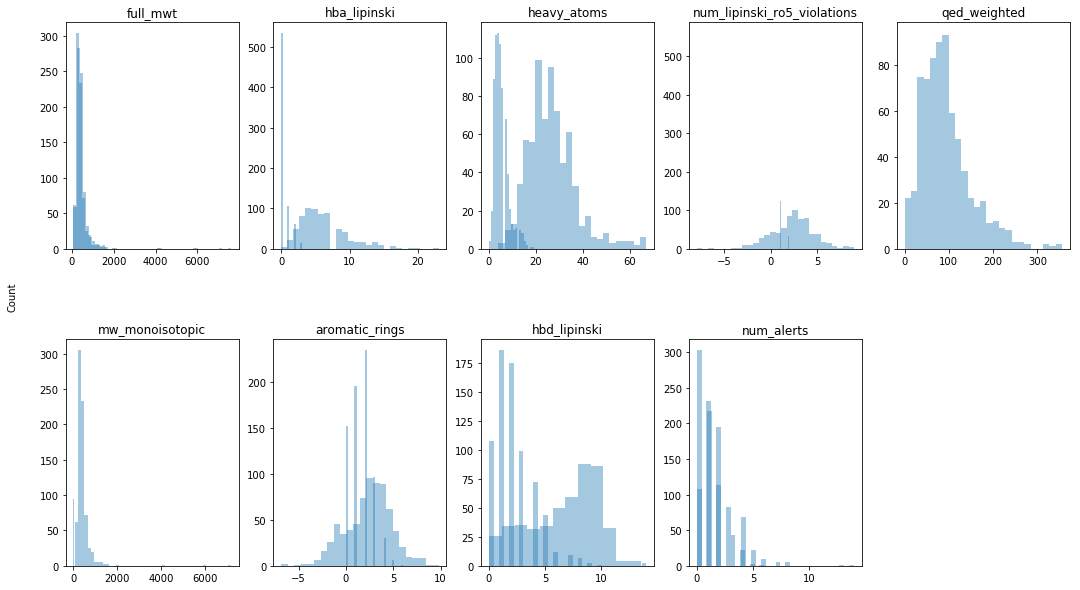

In [16]:
f, axes = plt.subplots(2, 5, figsize=(18, 10))
rows = 0
cols = 0
for c in dfm.columns:
    if dfm[c].dtypes.name == 'float64':
        # Plot a simple histogram with binsize determined automatically for each float column
        if c == 'first_approval': 
            pass
        else:
            sns.distplot(dfm[c].values, kde=False, color=pal, ax=axes[rows%2, cols%5])
            axes[rows%2,cols%5].set_title(c)
            rows += 1
            cols += 1
f.subplots_adjust(hspace=0.4)        
f.text(0.08, 0.5, 'Count', va='center', rotation='vertical');
# remove the last blank plot
f.delaxes(axes[1][4])

### column description with int64 dtype 

In [17]:
# change data type to int since these are counts
int_cols = ['hbd',\
            'hba',\
            'hbd_lipinski',\
            'hba_lipinski',\
            'num_ro5_violations',\
            'aromatic_rings',\
            'num_lipinski_ro5_violations',\
            'num_alerts',\
            'rtb',\
            'heavy_atoms']

for ic in int_cols:
    dfm[ic] = dfm[ic].fillna(0).astype(int)

In [18]:
dfm.dtypes

molregno                         int64
canonical_smiles                object
compound_name                   object
mw_freebase                    float64
alogp                          float64
hba                              int64
hbd                              int64
psa                            float64
rtb                              int64
ro3_pass                        object
num_ro5_violations               int64
acd_most_bpka                  float64
acd_logp                       float64
acd_logd                       float64
molecular_species               object
full_mwt                       float64
aromatic_rings                   int64
heavy_atoms                      int64
num_alerts                       int64
qed_weighted                   float64
mw_monoisotopic                float64
full_molformula                 object
hba_lipinski                     int64
hbd_lipinski                     int64
num_lipinski_ro5_violations      int64
max_phase                

In [19]:
# however two wont be plotted (doc_id and molregno)
len([c for c in dfm.columns if dfm[c].dtypes.name == 'int64'])

22

In [20]:
# create the indices prior and loop through the columns
rep = [0,1,2,3,4]
rep_lst = [(i,j) for i,j in zip(np.repeat(rep, 5), np.tile(rep, 5 ))]

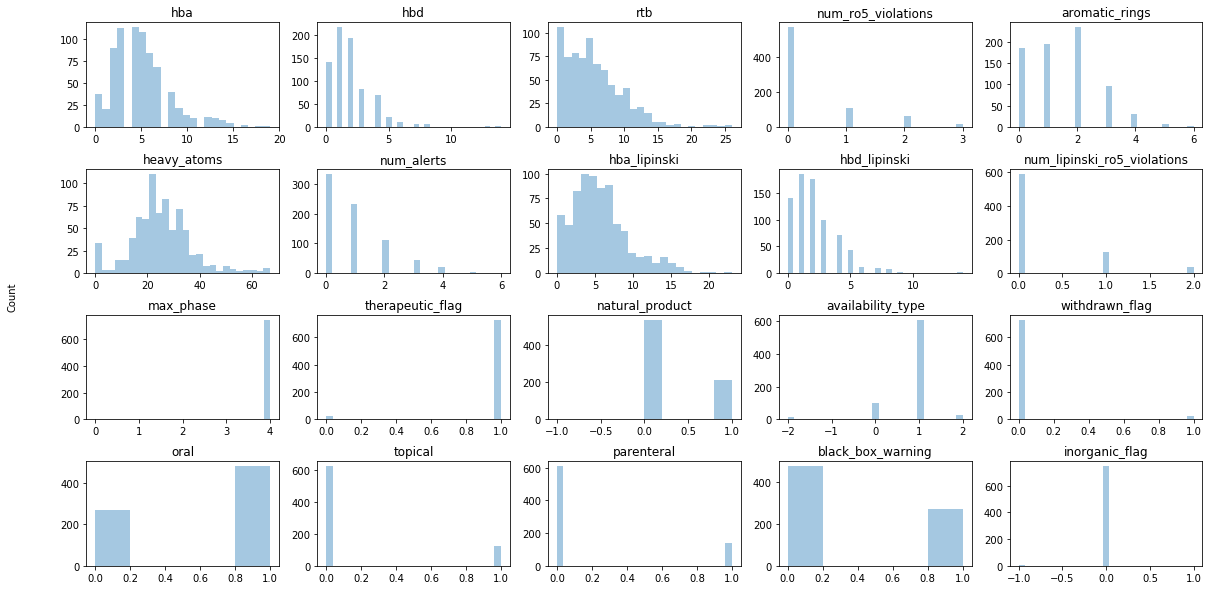

In [21]:
f, ax = plt.subplots(4,5, figsize=(20,10))
cnt = 0
for c in dfm.columns:
    if dfm[c].dtypes.name == 'int64' and c not in ['molregno', 'doc_id']:
        sns.distplot(dfm[c].values, kde=False, color=pal, ax=ax[rep_lst[cnt]])
        ax[rep_lst[cnt]].set_title(c)
        cnt +=1
        
f.text(0.07, 0.5, 'Count', va='center', rotation='vertical');
f.subplots_adjust(hspace=0.4)        

> - **hba** - number of hydrogen bond acceptors using original calculation. This distribution does not differ much from the lipinski hba distribution. 
> - **hbd** - is the number hydrogen bond donors using the original algorithm. Its distribution slightly differs only at the center, however there are very few data-points there. It is right skewed. 
> - **rtb** - is the number of rotatble bonds. Some bonds are more rigid than others. This distribution shows a very right-skewed shape. Many values lie under 6
> - **num_ro5_violations** - this is the number of violations against the lipinski rule of 5 for drug discovery which is based on other molecular descriptors described above. The less violations the better, however some compounds show drug-likeness even though they have 2-3 violations.
> - **aromatic_rings** - is the number of aromatic rings of the compound. Most drugs have aromaticity. This distribution is centered at 2
> - **heavy_atoms** are any atoms larger than the typical H, C, N, S, O, P atoms that consitute all life. There seems to be a uniform distribution of them within the 20-35 range.
> - **num_alerts** - these are high chemical reactivity molecular fragments or fragments that can be transformed via bioactivation by human enzymes into fragments with high chemical reactivity, that may cause adverse side-effects. This is very right skewed and shows majority of compounds in the 0 range, which is a good sign. 
> - **hba_lipinski** is the hydrgen bond acceptor which is an atom that accepts protons or postive charge. The calculation uses Lipinski's algorithm. The distribution is right-skewed and is more heavily dense in the 1-5 range
> - **hbd_lipinski** - is the hydrogen bond donor or typically a proton that donates a postive charge. The calculation uses Lipinski's algorithm. The distribution is sparse probably due to incorrect number of bins assigned. Nevertheless, the distrubtion is right skewed. 
> - **num_lipinksi_ro5_violations** - is the number of violations against Lipinski's rule of 5 using the lipinski hba and hbd values. The distribution shows values only in 0, 1 or 2 instead of the other type which is at 0, 1, 2 or 3.
> - **max_phase** - indicates what phase of the drug development cycle it is in, 4 being the max meaing it has been developed to market. Only a hand-full are in the beginning trial phase
> - **therapeutic_flag** - indicates that a drug has a therapeutic application (as opposed to e.g., an imaging agent, additive etc). Most compounds in this dataset have therapeutic application and only a handful are used for other purposes
> - **natural_product** - indicates whether the compound is a natural product-derived compound. about 200 compounds are natural products
> - **availability_type** - for the drug (0 = discontinued, 1 = prescription only, 2 = over the counter); the negative values mean there was no report. Most in this dataset are prescription-based
> - **withdrawn_flag** - indicates whether the drug has been withdrawn in at least one country (not necessarily in the US); this dataset includes comopunds that have not had many withdrawn from the market
> - **oral** - whether the drug is taken orally or not (1 or 0). Most drugs from this dataset are taken orally 
> - **topical** - whether the drug is administered topically or not (1 or 0). Most drugs from this dataset are not administered topically 
> - **parenteral** - whether the drug is administered parenterally or not (1 or 0). Most drugs from this dataset are not administered parenterally
> - **black_box_warning** - whether the drug packaging contains a warning or not. Over 400 drugs do not have the warning, however over 200 do
> - **inorganic_flag** - All drug compounds in this dataset are not inorganic, meaning they are all organic compounds

### column description with object (string) dtype 

In [22]:
# count of molecule type
molec_type = dfm.groupby('molecule_type').count()['molregno']
molec_type

molecule_type
Oligonucleotide      1
Oligosaccharide      1
Protein             16
Small molecule     730
Unknown              2
Name: molregno, dtype: int64

In [23]:
dfm.molecule_type.value_counts()

Small molecule     730
Protein             16
Unknown              2
Oligonucleotide      1
Oligosaccharide      1
Name: molecule_type, dtype: int64

In [24]:
# check how many do/do not pass the ro3 standard
df_ro3pass = dfm.ro3_pass.value_counts()
df_ro3pass

N    682
Y     35
Name: ro3_pass, dtype: int64

> - **row3_pass** indicates whether the compound passes the rule-of-three (mw < 300, logP < 3 etc); either Y or N
> - **molecule_type** whether the drug compound is a small molecule or protein-based or unknown
> - **country** what country was the compound first studied and developed as a marketable drug
> - **company** what company popularised the drug 
> - **dosage_form** what type of dosage method is adminsistered for the drug

> this univariate barplot below shows the number of molecule types. The most frequent type found in this dataset is small-molecule. The other types don't even compare

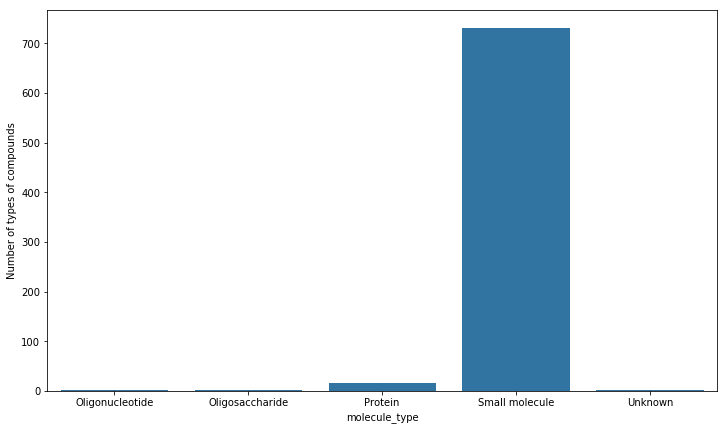

In [25]:
f, ax = plt.subplots(1,1,figsize=(12,7))
p = sns.barplot(x = molec_type.index, y = molec_type.values, color=pal)
p.set_ylabel('Number of types of compounds');

In [26]:
dfm.country.unique()

array(['USA', 'Japan', 'UK', 'Switzerland', 'Germany', 'Denmark', 'Italy',
       'France', 'Australia', 'Spain', 'Hungary', 'Belgium', 'Finland',
       'italy', 'Korea', 'Norway', 'Canada'], dtype=object)

In [27]:
# reassign one row with a lowercase 'i' for the country name
dfm.at[dfm[dfm.country == 'italy'].index.values[0], 'country'] = 'Italy'

In [28]:
# create a drug compound count by country dataset 
cmpd_country = dfm.groupby('country').count().sort_values('molregno', ascending=False)['molregno']

In [29]:
dfm['country'].value_counts()

USA            423
UK              97
Switzerland     72
France          40
Japan           39
Germany         35
Italy           22
Spain            5
Denmark          5
Belgium          3
Finland          3
Hungary          2
Norway           1
Australia        1
Korea            1
Canada           1
Name: country, dtype: int64

In [30]:
cmpd_country

country
USA            423
UK              97
Switzerland     72
France          40
Japan           39
Germany         35
Italy           22
Denmark          5
Spain            5
Belgium          3
Finland          3
Hungary          2
Australia        1
Canada           1
Korea            1
Norway           1
Name: molregno, dtype: int64

> this univariate barplot shows the number of drugs that were developed by x-country; the US shows the highest number

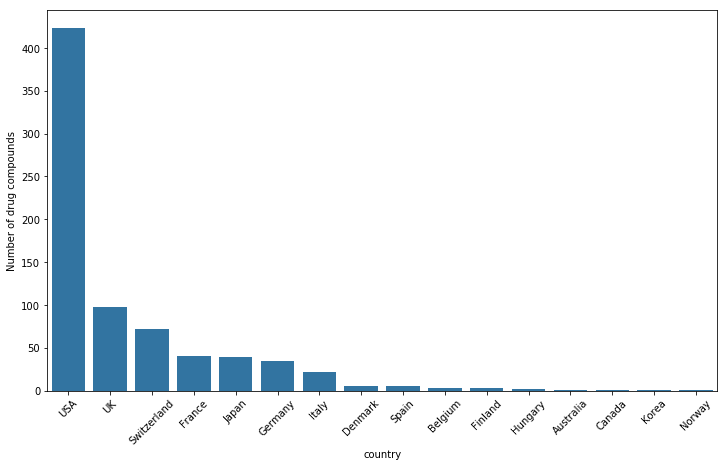

In [31]:
f, ax = plt.subplots(1,1,figsize=(12,7))
p = sns.barplot(x = cmpd_country.index, y=cmpd_country.values, color=pal, ax = ax)
p.set_xticklabels(cmpd_country.index, rotation=45);
p.set_ylabel('Number of drug compounds');

In [32]:
dfm.company.unique()

array(['Elorac', '3M Pharmaceuticals', 'Pharmacyclics', 'Pfizer',
       'Mitsubishi Kasei', 'Essential Nutrition', 'Roche', 'AstraZeneca',
       'Dow AgroSciences', 'Merck', 'CV Therapeutics', 'Eli Lilly',
       'Alcon Labs.', 'Remedy Pharmaceuticals', 'Celgene',
       'Ohmeda Pharm. Prods.', 'Monsanto', 'Bayer-Schering',
       'Scotia Pharmaceuticals', 'DaiichiSankyo', 'Lundbeck',
       'Alfa Wassermann', 'Otsuka', 'GlaxoSmithKline', 'Astellas',
       'SRI International', 'DuPont', 'Merck-Serono', 'Poli Group',
       'Takeda', 'Ligand Pharmaceuticals', 'Alexza', 'Acadia',
       'Bristol-Myers Squibb', 'Abbott Laboratories', 'SanofiAventis',
       'Carter-Wallace', 'Nelson Res. & Dev.', 'Forest', 'Knoll',
       'Cephalon', 'Phase 2 Discovery', 'Novogen', 'Ferrer', 'Sanwa',
       'TAP Pharmaceuticals', 'Taisho Seiyaku', 'Biogglan Labs',
       'Grunenthal', 'Antigenics', 'Gilead Sciences', 'Incyte', 'Vertex',
       'Gedeon Richter', 'Boehringer-Ingelheim', 'Novartis', 'Acce

In [33]:
compy = dfm.groupby('company').count().sort_values(by='molregno', ascending=False)['molregno']
compy

company
Pfizer                       114
Merck                         61
GlaxoSmithKline               53
Roche                         44
SanofiAventis                 37
Bristol-Myers Squibb          34
Novartis                      26
3M Pharmaceuticals            23
Bayer-Schering                23
AstraZeneca                   18
Monsanto                      16
Ohmeda Pharm. Prods.          15
Eli Lilly                     13
Scotia Pharmaceuticals        11
Johnson & Johnson             10
DuPont                         8
Gilead Sciences                8
Poli Group                     8
Abbott Laboratories            7
Carter-Wallace                 7
Takeda                         6
Astellas                       6
Otsuka                         6
Biogglan Labs                  6
Alcon Labs.                    5
SRI International              5
Sanwa                          5
Elorac                         5
Remedy Pharmaceuticals         5
Essential Nutrition            5
  

> this univariate barplot shows that Pfizer has developed the most drugs out of all the other companies in the dataset (followed by Merck and GlaxoSmithKline)

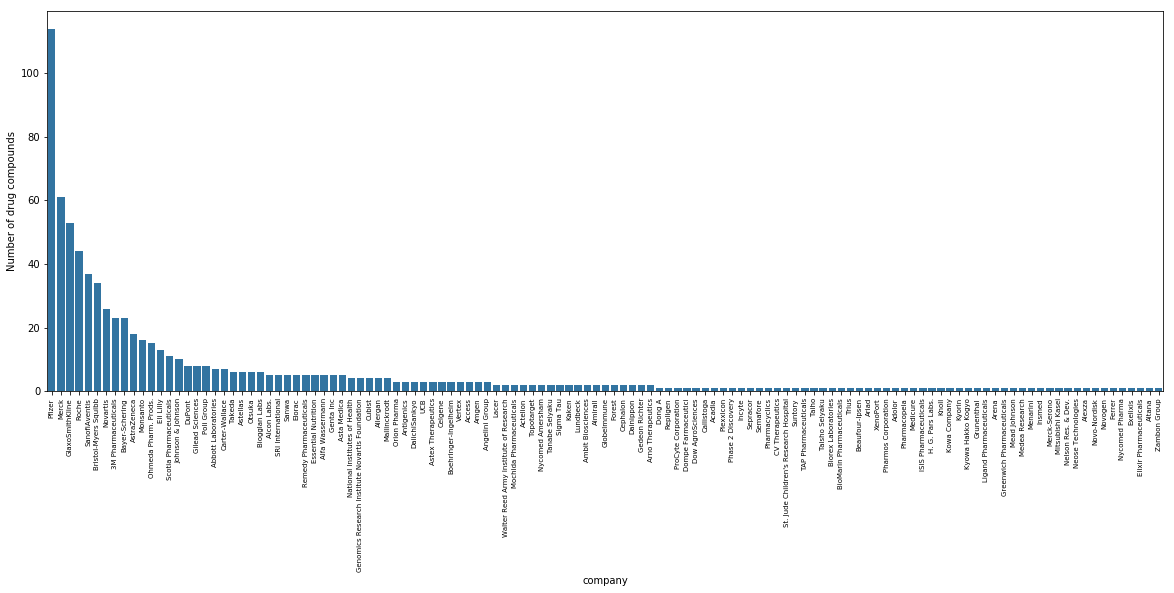

In [34]:
# plot barplot of all types of companies in the dataset
f, ax = plt.subplots(1,1,figsize=(20,7))
p = sns.barplot(x = compy.index, y=compy.values, color=pal, ax = ax)
p.set_xticklabels(compy.index, rotation=90,fontdict={'fontsize':7});
p.set_ylabel('Number of drug compounds');

In [35]:
# check out the unique values of dosage form column
dfm.dosage_form.unique()

array(['SOLUTION', 'TABLET', 'CAPSULE', 'INSERT, EXTENDED RELEASE',
       'INJECTABLE', 'FOR SUSPENSION, EXTENDED RELEASE', 'CREAM',
       'TABLET, EXTENDED RELEASE', 'TABLET, ORALLY DISINTEGRATING',
       'SUSPENSION/DROPS', 'AEROSOL, METERED', 'SOLUTION/DROPS', 'POWDER',
       'GEL', 'AEROSOL, FOAM', 'TABLET, DELAYED RELEASE', 'PASTE',
       'CAPSULE, DELAYED RELEASE', 'CAPSULE, EXTENDED RELEASE',
       'TABLET, CHEWABLE', 'INJECTABLE, LIPOSOMAL', 'CONCENTRATE',
       'FOR SUSPENSION', 'SPRAY, METERED', 'FILM, EXTENDED RELEASE',
       'FOR SOLUTION', 'SUSPENSION', 'CAPSULE, DELAYED REL PELLETS',
       'EMULSION', 'TABLET, EFFERVESCENT', 'OINTMENT', 'POWDER, METERED',
       'TABLET, FOR SUSPENSION', 'LIQUID', 'SUPPOSITORY', 'FILM', 'SYRUP',
       'INTRAUTERINE DEVICE', 'SHAMPOO', 'RING', 'TAMPON'], dtype=object)

In [36]:
# sort by count
dose = dfm.groupby('dosage_form').count().sort_values('molregno', ascending=False)['molregno']
dose

dosage_form
TABLET                              297
INJECTABLE                          121
CAPSULE                             108
CREAM                                34
TABLET, EXTENDED RELEASE             33
SOLUTION/DROPS                       30
SOLUTION                             21
POWDER                               13
TABLET, ORALLY DISINTEGRATING         9
TABLET, CHEWABLE                      9
SUSPENSION/DROPS                      9
GEL                                   5
CAPSULE, EXTENDED RELEASE             5
AEROSOL, FOAM                         4
TABLET, DELAYED RELEASE               4
CAPSULE, DELAYED RELEASE              4
FILM, EXTENDED RELEASE                4
SUSPENSION                            3
AEROSOL, METERED                      3
SPRAY, METERED                        3
OINTMENT                              3
CAPSULE, DELAYED REL PELLETS          3
FOR SOLUTION                          3
PASTE                                 2
FOR SUSPENSION, EXTENDED REL

> this plot shows the number of types of drug dosage types, tablet being the most common

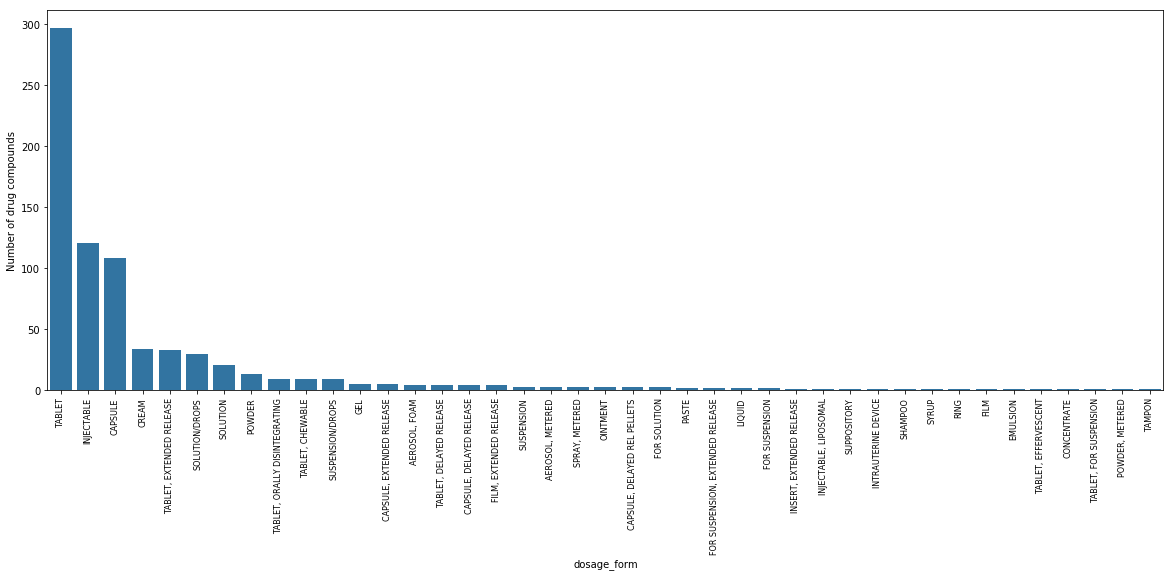

In [37]:
f, ax = plt.subplots(1,1,figsize=(20,7))
p = sns.barplot(x = dose.index, y= dose.values, color=pal, ax = ax)
p.set_xticklabels(dose.index, rotation=90,fontdict={'fontsize':8});
p.set_ylabel('Number of drug compounds');

> as noted earlier, the molecular weight features are expected to be similar, and as can be seen from their general statistics they are. Only the full_mwt shows a slight variation

In [38]:
dfm.full_mwt.describe()

count     750.000000
mean      463.672533
std       426.957893
min        73.890000
25%       302.915000
50%       392.430000
75%       505.027500
max      7594.800000
Name: full_mwt, dtype: float64

In [39]:
dfm.mw_monoisotopic.describe()

count     740.000000
mean      428.545606
std       407.617757
min        76.027300
25%       290.803575
50%       361.605300
75%       468.117575
max      7172.091700
Name: mw_monoisotopic, dtype: float64

In [40]:
dfm.mw_freebase.describe()

count     740.000000
mean      428.973270
std       407.883391
min        76.050000
25%       291.142500
50%       361.830000
75%       468.425000
max      7177.150000
Name: mw_freebase, dtype: float64

In [41]:
# number of extreme values for full_mwt (full molecular weight) eyeballed from the histogram
# these are not outliers, they are simply extreme values that are not common
# more specifically they are peptides or protein-based compounds that are large macromolecules
# the smaller compounds are probably simple molecules that have unique physicochemical properties
sum((dfm.full_mwt > 1000) | (dfm.full_mwt < 100))

36

In [42]:
dfm.full_mwt[:20]

0      826.00
1     1001.14
2      440.50
3      352.47
4      313.78
5      286.71
6      508.63
7      341.40
8     1570.32
9      532.46
10     308.76
11     606.77
12      94.11
13     372.54
14     427.54
15     312.43
16     461.55
17     383.51
18     602.66
19     322.27
Name: full_mwt, dtype: float64

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The dataset is quite sparse. Most distributions are right-skewed and those right-sided bars contain just a handful of datapoints. The molecular weights vary tremendously, however due to the scarity of in-between values for molecular weight, it was deemed unncessary to transform the axis. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> In the 'country' column 'italy' and 'Italy' was found, also there were quite a bit of NaN's in the dataset. Simply indexing the dataframe without NaNs was done to only analyse full rows.  

## Bivariate Exploration <a class="anchor" id="bivariate"></a>

#### investigate indication class; the type of ailment the drug treats

In [43]:
# there are actually over 100 types
dfm.indication_class.unique()[:25]

array([nan, 'Oxytocic; Prostaglandin', 'Antidepressant',
       'Tranquilizer (minor)', 'Anticoagulant',
       'Antagonist (to narcotics)', 'Gonad-Stimulating Principle',
       'Antifungal', 'Sedative-Hypnotic',
       'Multiple Sclerosis Symptomatic Treatment',
       'Inhibitor (alpha reductase)', 'Anti-Anginal', 'Antipsychotic',
       'Antiglaucoma Agent', 'Inhibitor (beta-lactamase)',
       'Amyotrophic Lateral Sclerosis Treatment', 'Analgesic',
       'Antinauseant; Anti-Emetic', 'Anti-Inflammatory', 'Antibacterial',
       'Bronchodilator', 'Progestin', 'Antihypertensive',
       'Glucocorticoid', 'Anti-Emetic'], dtype=object)

In [44]:
# splits the string value (indication class) and returns the elements that are of interest
def split_string_value(string_value):
    lst_of_strs = []
    if ';' in string_value:
        words = string_value.split(';')
        for w in words:
            if '(' in w:
                lst_of_strs.append(w.split('(')[0].strip())
            else:
                lst_of_strs.append(w)
    elif '(' in string_value:
        lst_of_strs.append(string_value.split('(')[0].strip())
    else:
        lst_of_strs.append(string_value)
    return lst_of_strs 

In [45]:
# get unique values from column 
ind_cls = dfm.indication_class.unique().tolist()
# remove NaN
ind_cls = [x for x in ind_cls if not pd.isna(x)]
# split the words and insert into list
ind_cls = [split_string_value(ic) for ic in ind_cls]

In [46]:
# remove the string that does not conform to standard and then manually add back 
# into list; they were attached strings like 'Analgesic,Antipyretic' &   
# Osteoporosis Therapy Adjunct,Osteoporosis Therapy Adjunct,Osteoporosis Therapy Adjunct  
to_add_back_1 = ['Antipyretic',
'Analgesic',
'Antipyretic',
'Anti-Inflammatory',
'Analgesic',
'Dementia Symptoms Treatment Adjunct',
'Inhibitor',
'Cognition Adjuvant',
"Alzheimer's Disease Treatment",
'Bone Resorption Inhibitor',
'Osteoporosis Therapy Adjunct',
'Bone Resorption Inhibitor']

In [47]:
 # find the indices manually (52, 60, 115, 180)
for i,j in enumerate(ind_cls):
    if any([x in j for x in to_add_back_1]) and len(j) != 1:
        print(i,j)

43 ['Antipyretic', ' Anti-Inflammatory', ' Analgesic']
52 ['Anti-Inflammatory', 'Analgesic,Inhibitor']
60 ['Dementia Symptoms Treatment Adjunct', 'Inhibitor', ' Cognition Adjuvant', "Alzheimer's Disease Treatment"]
76 ['Analgesic', ' Anticonvulsant']
77 ['Anti-Inflammatory', ' Analgesic']
84 ['Synergist', 'Inhibitor']
115 ['Bone Resorption Inhibitor', ' Osteoporosis Therapy Adjunct,Osteoporosis Therapy Adjunct,Osteoporosis Therapy Adjunct', ' Bone Resorption Inhibitor']
139 ['Cognition Adjuvant', ' Dementia Symptoms Treatment Adjunct']
163 ['Inhibitor', ' Vasodilator', ' Antithrombotic']
171 ['Inhibitor', ' Antihyperlipidemic']
180 ['Anti-Inflammatory', ' Antipyretic', ' Analgesic,Antipyretic', ' Anti-Inflammatory', ' Analgesic']
184 ['Anti-Allergic', 'Inhibitor']


In [48]:
# remove the words from list that have trouble strings
ind_cls = [icls for idx,icls in enumerate(ind_cls) if idx not in [52,60,115,180]]
# flatten the list of lists
ind_cls = list(set([item.strip() for sublist in [ic for ic in ind_cls] for item in sublist]))

In [49]:
len(ind_cls)

123

In [50]:
# manually remove these and add them back in as well bc they had attached strings with ',' in between
idx_to_rm = []
for i,c in enumerate(ind_cls):
    if ',' in c:
        print(i,c)
        idx_to_rm.append(i)
        
ind_cls = [ic for idx, ic in enumerate(ind_cls) if idx not in idx_to_rm]

30 Antiviral,Antiviral
38 Anti-Infective, Topical
43 Anti-Inflammatory,Anti-Inflammatory
47 Antibacterial,Antiprotozoal
54 Antihistaminic, H1-Receptor
79 Anesthesia, Adjunct To


In [51]:
to_add_back_2 = ['Anti-Inflammatory',
'Antibacterial', 
'Antiprotozoal',
'Anesthesia', 
'Anti-Infective', 
'Topical',
'Antihistaminic', 
'H1-Receptor',
'Antiviral']

In [52]:
# add all the lists back together 
ind_cls = ind_cls + to_add_back_1 + to_add_back_2
# make a set of unique values
ind_cls = list(set([c.strip() for c in ind_cls]))

In [53]:
ind_cls[:15]

['Antischistosomal',
 'Suppressant',
 'Radioprotector',
 'Neuromuscular Blocking Agent',
 'Antimanic',
 'LHRH Agonist',
 'Androgen',
 'Antipyretic',
 'Dementia Symptoms Treatment Adjunct',
 'Glucocorticoid',
 'Antihypotensive',
 'Cardiac Depressant',
 "Paget's Disease Treatment",
 'Diuretic',
 'Topical']

In [54]:
# number of different indication classes
len(ind_cls)

122

In [55]:
# initialise a count dictionary with 0 values
ind_cls_cnt_dct = {k:0 for k in ind_cls}

In [56]:
# loop thru column and count the amount of times an indication class pops up
for idx,ic in enumerate(dfm.indication_class):
    if pd.isna(ic):
        pass
    else:
        splt_ic = split_string_value(ic)
        for ic_s1 in splt_ic:
            if ',' in ic_s1:
                inner_splt_ic = ic_s1.split(',')
                for ic_s2 in inner_splt_ic:
                    try:
                        ind_cls_cnt_dct[ic_s2.strip()]+=1
                    except KeyError:
                        print(f'not found: {idx} - {ic}')
            else:
                try:
                    ind_cls_cnt_dct[ic_s1.strip()]+=1
                except KeyError:
                    print(f'not found: {idx} - {ic}')

not found: 566 - Anesthesia, Adjunct To


In [57]:
# manually add one count since it was not found due to comma (the code did not detect this one)
ind_cls_cnt_dct['Anesthesia']+=1

In [58]:
# convert to pandas dataframe
df_ic = pd.DataFrame(list(ind_cls_cnt_dct.items()), columns = ['indication_class', 'count'])
df_ic.head()

,indication_class,count
0,Antischistosomal,1
1,Suppressant,1
2,Radioprotector,1
3,Neuromuscular Blocking Agent,8
4,Antimanic,1


In [59]:
# use seaborn colour palette
colour_palette = sns.color_palette()

In [60]:
# add colour column into df
df_ic['colour'] = df_ic['count'].apply(lambda x: colour_palette[1] if x > 10 else colour_palette[0])

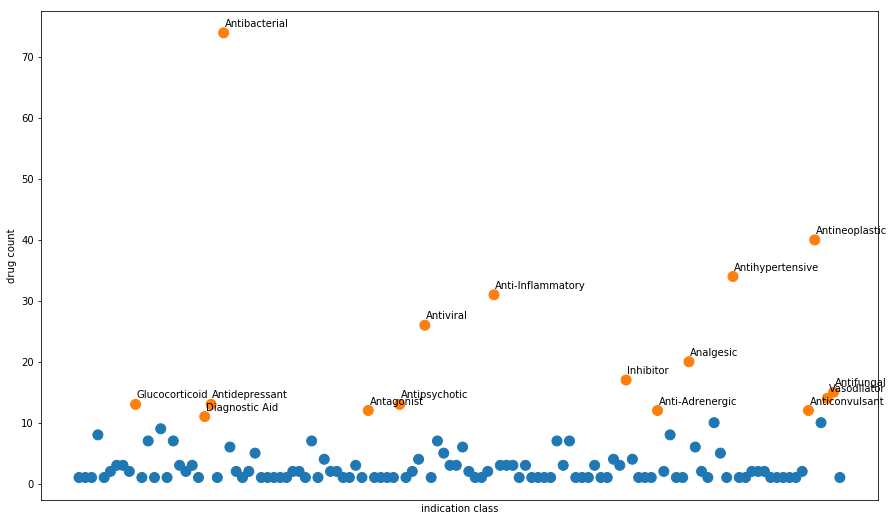

In [61]:
# plot scatter based on colour for count values > 10
# annotated by the indication class (since there are over 100 types, just annotate the top ones)
fig, ax = plt.subplots(1,1,figsize=(15,9))
ax.scatter(x=df_ic['indication_class'], y=df_ic['count'], s=100, c=df_ic['colour'])
plt.xticks([]);
plt.ylabel('drug count')
plt.xlabel('indication class')
for top_icls in df_ic[df_ic['count'] > 10]['indication_class'].values:
    x = df_ic.index[df_ic.indication_class == top_icls].item()
    y = df_ic[df_ic.indication_class == top_icls]['count'].item()
    ax.annotate(top_icls, xy=(x + 0.2, y + 1))

> the scatter plot above shows that the most common indication class drug is antibacterial, the runner ups are anti-inflammatory, anti-hypertensive and anti-neoplastic. This accord to commmon knowledge that most drugs target these kinds of treatments

In [63]:
# get numeric variables from dataframe
numeric_vars = [colm for colm in dfm.columns if dfm[colm].dtype == 'float64' and colm != 'first_approval']

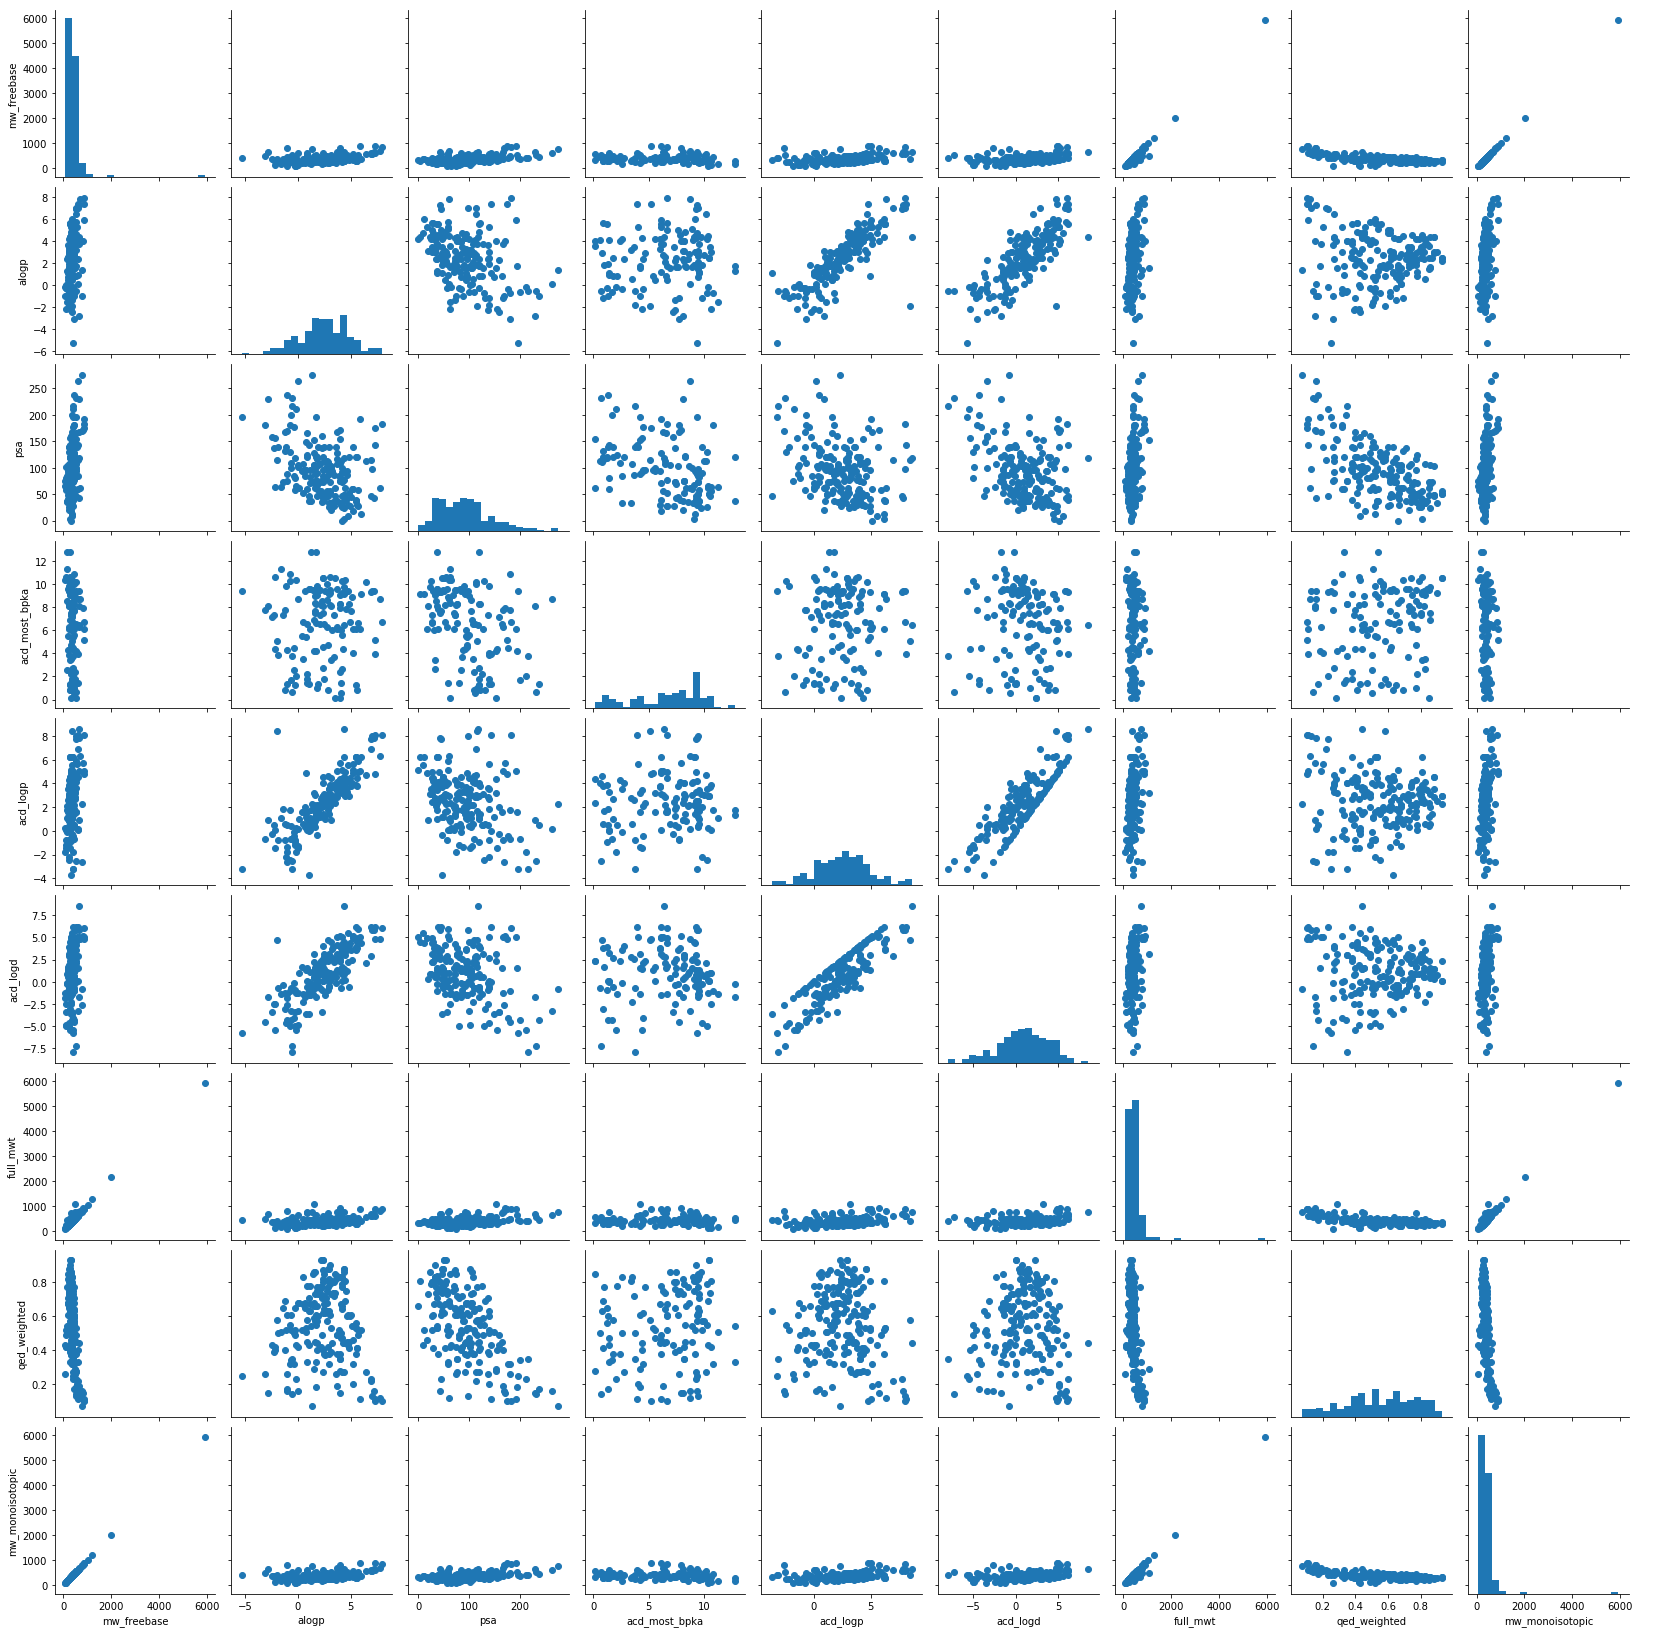

In [64]:
# plot matrix: sample 200 rows 
samples = np.random.choice(dfm.shape[0], 200, replace = False)
dfm_samp = dfm.loc[samples,:]

g = sns.PairGrid(data = dfm_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

> - this grid plot shows a trimmed down version of the numeric variables in the dataset. Since there are many similar types; manual removal of some was done to make a more interpretable plot. On the diagonal, there are histograms which have been dealt with in the first plot figure above. THe off-diagonal are scatter plots that don't show much linear correlation. The strongest positive correlation observed is psa vs hbd and hba. This would suggest that polar surface area and hydrogen bond donor as well as acceptor are somewhat correlated. What else is interesting is the full_mwt (full moelcular weight). As the y-axis numerical variables vary, the molecular weight does not. Molecular weight is irrespective of these numeric variables. 

### faceted boxplot to show relationship of qed score and molecular weight against molecule type, ad type and route

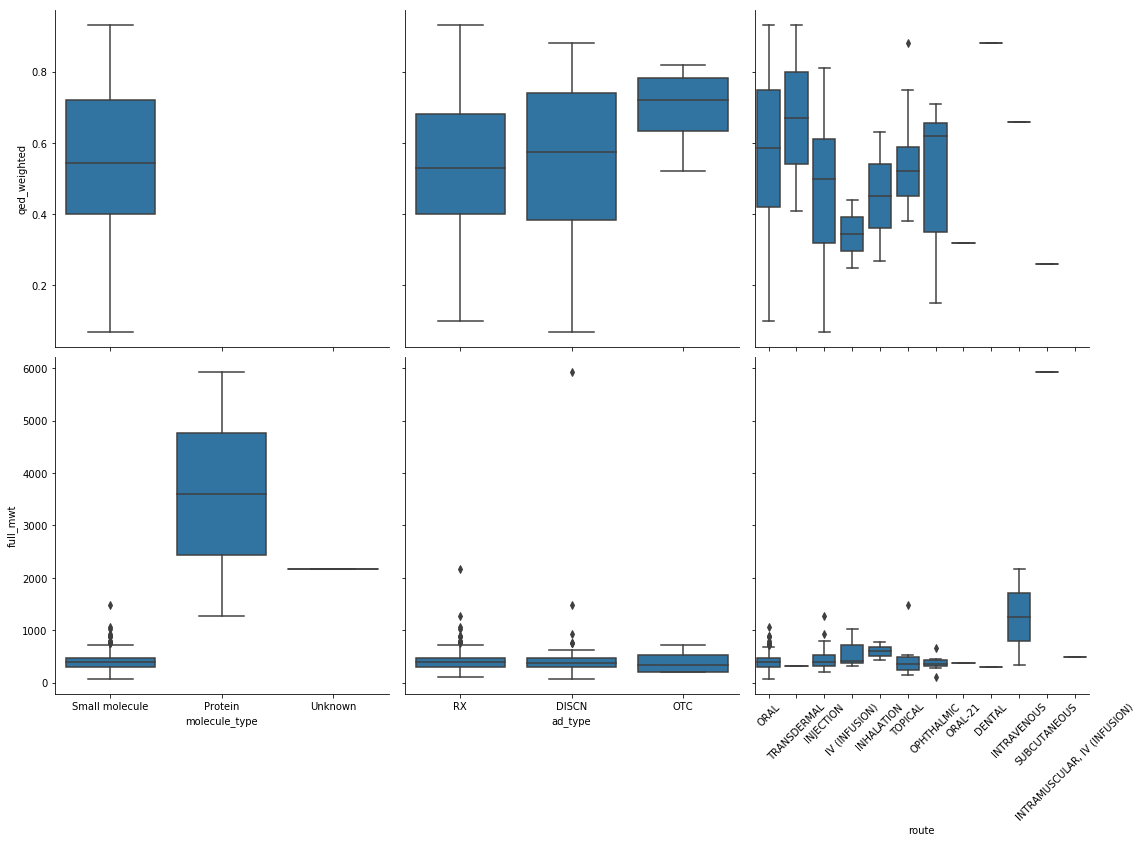

In [65]:
# setup two categorical variables to look at
var_lst = ['molecule_type',\
            'ad_type',\
            'route']
# function taken from diamond dataset example to quickly plot a boxplot using seaborns PairGrid
def boxgrid(x, y, **kwargs):
    default_color = sns.color_palette()[0]
    sns.boxplot(x, y, color = default_color)

#plt.figure(figsize = [18, 12])
g = sns.PairGrid(data = dfm_samp,\
                 y_vars = ['qed_weighted', 'full_mwt'],\
                 x_vars = var_lst, height = 5)
g.map(boxgrid);
# rotate the x-tick labels for readability
for i,ax in enumerate(g.axes.flat): 
    if i == 5:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

> - The right side of the grid boxplot shows that drug compounds that use subcutaneous routes have very high molecular weights. Injection types show a relatively varied range of molecular weights, likewise with oral types. Other route types have very tightly spaced datatpoints with little variation. In regards to the QED value; IV infusion, vaginal, inhalation, subcutaneous routes have relatively low values compared to oral, injection and topical which are the more commmonly known types of routes. One thing that comes to mind is, perhaps, these less common routes are so because they aren't as efficacious based on the qed value. 
 
> - On the left side of the grid boxplot, it can be seen that small molecules obviously have low molecular weights and can be up to around 1000 daltons which is quite large, however not compared to proteins (peptides/macromolecules) which can be up to 6000. QED values for proteins and peptides are very low. The variation of QED values for small molecules is very broad, however the mode is around 0.5 

> - The middle boxplot shows the administration type. Prescribed drugs have various molecular weights, whereas OTC drugs are all small-molecules. Discontinued drugs are also quite varied. It is interesting to observe that OTC drugs are not considerd highly drug-like according to QED values, perhaps that is why they are OTC; so that patients can buy them thinking they are efficacious, but they are not. In the end pharmaceutical companies will siphon all the money out of sick people while the sick don't get any better, but think they need the drug. It is OTC, so they are accessible and at times relatively inexpensive. Prescribed drugs and discontinued drugs have highed qed values, overall. 


### Visualise the chemical compounds

In [66]:
# a SMARTs string search of the canconical smiles string (molecular formula); 
# returns the chemical structure  with matching sub-structure highlighted in green
# this will provide a visualisation of the common sub-structures in this dataset

# just for visualising one compound for testing
def smart_search(query, smi, name): 
    mol = pybel.readstring('smi',smi)
    mol.title = name
    smarts = pybel.Smarts(query)
    if smarts.findall(mol):    
        print(f'smart found for {query} in {name}')
        highlighter = pybel._operations['highlight']
        highlighter.Do(mol.OBMol, query+' green')
    return mol.write('svg', opt={"u":None,"C":None,"P":500,'b':'transparent','B':'white','d':None}).strip()

# to place a flag on the drug compound whether any of the chemical subgroups are found as a sub-structure; returns True or False
def smart_search_flag(query, smi): 
    mol = pybel.readstring('smi',smi)
    smarts = pybel.Smarts(query)
    if smarts.findall(mol):    
        return True
    return False

> pyridine, ester, ether, benzene, cyclohexane, cyclopentane, nitrile, pyrole, furane, oxy-cyclopentane, oxy-cyclohexane, cyclopentanone, cyclohexanone, terpene, double-bond and peptide-bond chemical subgroups are quite common in the chemical space. These chemical subgroups were used due to its ubiquitous nature

In [67]:
# make a chemical sub-group dictionary with canonical smiles values. these will be categorical. 
# we can count how many of these subgroups are found in the dataset
# this dictionary was not taken from any source, it is quite arbitrary but based on prior knowledge of chemistry
chem_subgrp_dct = {
    'pyridine':'n1ccccc1',
    'ester' : 'C(=O)O',
    'ether' : 'COC',
    'benzene': 'c:c', 
    'nitrile': 'C#N', 
    'oxy-cyclopentane' : 'C1CCCO1',
    'oxy-cyclohexane' : 'C1CCCCO1',
    'cyclopentanone': 'C1(CCCC1)=O',
    'cyclohexanone': 'C1(CCCCC1)=O',
    'cyclohexane': 'C1CCCCC1',
    'terpene' : 'CC(=C)C',
    'double-bond' : '[c,C]=[c,C]',
    'peptide-bond' : 'CC(=O)NC'
}

smart found for c:c in Terconazole


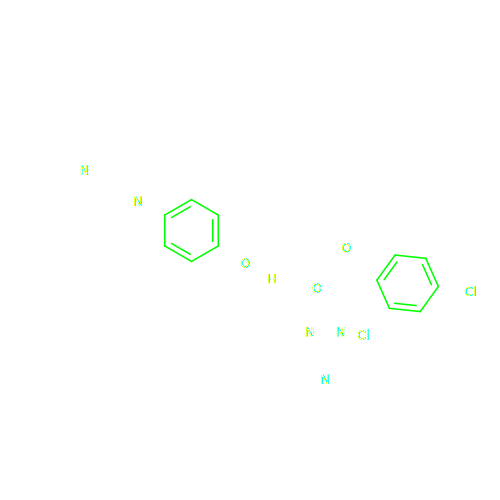

In [68]:
# for visual testing of one compound; the highlighted green indicates a sub-structure match 
# the chemical subgroup of interest, in this case it is benzene
SVG(smart_search(chem_subgrp_dct["benzene"], dfm['canonical_smiles'][9], dfm['compound_name'][9]))

In [69]:
# see what subgroups exists in the top 10 compounds listed in the dataframe
for i in range(10):
    for sb,sb_smi in chem_subgrp_dct.items():
        if smart_search_flag(sb_smi, dfm['canonical_smiles'][i]):
            print(sb)
        print(f'{i} - ######')

0 - ######
0 - ######
ether
0 - ######
0 - ######
0 - ######
oxy-cyclopentane
0 - ######
oxy-cyclohexane
0 - ######
0 - ######
0 - ######
0 - ######
terpene
0 - ######
double-bond
0 - ######
0 - ######
1 - ######
ester
1 - ######
1 - ######
benzene
1 - ######
1 - ######
1 - ######
1 - ######
1 - ######
1 - ######
1 - ######
1 - ######
double-bond
1 - ######
1 - ######
2 - ######
2 - ######
2 - ######
benzene
2 - ######
2 - ######
2 - ######
2 - ######
2 - ######
2 - ######
2 - ######
2 - ######
double-bond
2 - ######
peptide-bond
2 - ######
3 - ######
ester
3 - ######
3 - ######
3 - ######
3 - ######
3 - ######
3 - ######
cyclopentanone
3 - ######
3 - ######
3 - ######
3 - ######
double-bond
3 - ######
3 - ######
4 - ######
4 - ######
4 - ######
benzene
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
4 - ######
5 - ######
5 - ######
5 - ######
benzene
5 - ######
5 - ######
5 - ######
5 - ######
5 - ######
5 - ######
5 - ######
5 - ####

In [70]:
# initialise dataframe 
dfmc = pd.DataFrame() 

In [71]:
# make a new column for each of the chemical subgroups which returns a True/False
for sbg, sbg_smi in chem_subgrp_dct.items():
    dfmc[f'{sbg}_subgroup'] = dfm['canonical_smiles'].apply(lambda x: smart_search_flag(sbg_smi, x))

In [72]:
dfmc.head()

,pyridine_subgroup,ester_subgroup,ether_subgroup,benzene_subgroup,nitrile_subgroup,oxy-cyclopentane_subgroup,oxy-cyclohexane_subgroup,cyclopentanone_subgroup,cyclohexanone_subgroup,cyclohexane_subgroup,terpene_subgroup,double-bond_subgroup,peptide-bond_subgroup
0,False,False,True,False,False,True,True,False,False,False,True,True,False
1,False,True,False,True,False,False,False,False,False,False,False,True,False
2,False,False,False,True,False,False,False,False,False,False,False,True,True
3,False,True,False,False,False,False,False,True,False,False,False,True,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False


In [73]:
# count the number of each individual subgroup for each drug compound
# and save to a list
sbgp_count = []
for c in dfmc.columns:
    sbgp_count.append(dfmc[c].sum())

In [74]:
# the count for each chemical subgroup
sbgp_count

[85, 330, 234, 606, 18, 26, 31, 5, 7, 109, 126, 197, 166]

In [75]:
len(sbgp_count)

13

In [76]:
# sort the dictionary by count value descending
chem_subgrp_dct_order = {csb: cnt for csb, cnt in zip(chem_subgrp_dct.keys(), sbgp_count)}
chem_subgrp_dct_order = sorted(chem_subgrp_dct_order.items(), key=lambda x:x[1], reverse=True)
chem_subgrp_dct_order = {csb: cnt for csb,cnt in chem_subgrp_dct_order}

In [77]:
chem_subgrp_dct_order

{'benzene': 606,
 'ester': 330,
 'ether': 234,
 'double-bond': 197,
 'peptide-bond': 166,
 'terpene': 126,
 'cyclohexane': 109,
 'pyridine': 85,
 'oxy-cyclohexane': 31,
 'oxy-cyclopentane': 26,
 'nitrile': 18,
 'cyclohexanone': 7,
 'cyclopentanone': 5}

In [78]:
# function to write chemical structure to png files from canonical smiles so 
# that it can be read as an array using matplotlib for embedding
def export_chem_png(smi, file_name):
    mol = pybel.readstring('smi',smi)
    file_path = os.path.join(os.getcwd(), 'images')
    svgp = f'{file_name}.svg'
    pngp = f'{file_name}.png'
    mol.write('svg',\
              os.path.join(file_path, svgp),\
              opt={"u":None,"C":None,"P":500,'b':'transparent','B':'black','d':None},\
              overwrite=True)
    cairosvg.svg2png(url=os.path.join(file_path, svgp),\
                     write_to=os.path.join(file_path, pngp))

In [79]:
# export the chemical images to file
for csb, csb_smi in chem_subgrp_dct.items():
    # these have to be re-assigned to canonical smiles format
    # the dictionary uses a SMARTS string format
    if csb == 'benzene':
        csb_smi = 'C1=CC=CC=C1'
    elif csb == 'double-bond':
        csb_smi = 'C=C'
    export_chem_png(csb_smi, csb)

In [80]:
# helper function to read png file from path and convert into numpy array for plotting
# path is assigned globally from cwd
def add_artist_fig(ax, file_name, x0, x_offset, h, y_offset=60):
    im = image.imread(os.path.join(path, f'{file_name}.png'), format='png')
    im = OffsetImage(im, zoom=0.2)
    ab = AnnotationBbox(im, (x0+x_offset,h+y_offset),
                        xycoords='data',
                        boxcoords="data",
                        frameon=False
                       )
    ax.add_artist(ab)

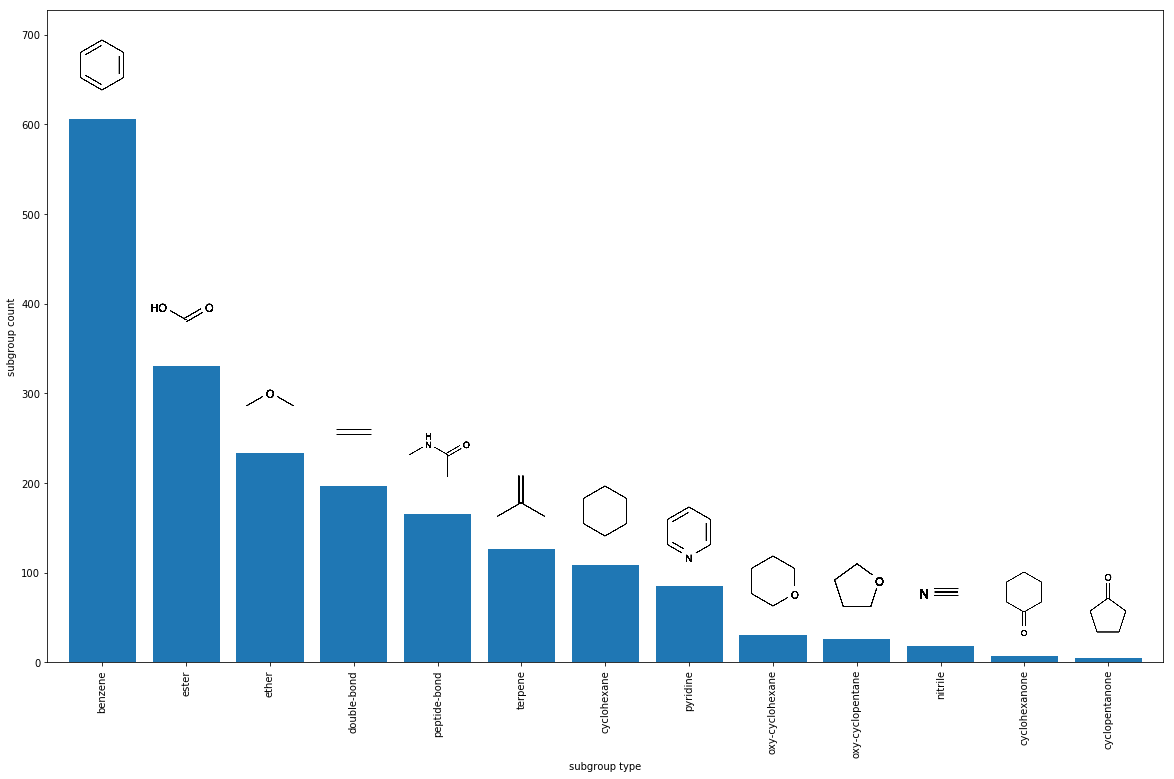

In [81]:
# plot barplot of chemical subgroups commmonly found in drug compounds
fig, ax = plt.subplots(figsize=(20,12))
# set the parent directory of the jupyter notebook
path = os.path.join(os.getcwd(), 'images')
# plot the barplot 
g = ax.bar(x=[csb for csb in chem_subgrp_dct_order.keys()],\
           height=[cnt for cnt in chem_subgrp_dct_order.values()])
# look thru each bar and add the chemical structure from the exported png file above
for i,csb in enumerate(chem_subgrp_dct_order.keys()): 
    b = g[i]
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
    # lower right vertex
    x1, y1 = x0+w,y0
    # get the midpoint between two vertices
    x_offset = (x1-x0)/2
    # add the offset to the x0 value to get to the middle
    # add the chemical structure on top of the bar
    add_artist_fig(ax, csb, x0, x_offset, h)

# assign the x-tick labels
ax.set_xticklabels([csb for csb in chem_subgrp_dct_order.keys()],rotation=90)
ax.set_ylabel('subgroup count')
ax.set_xlabel('subgroup type')
# allow some padding
plt.margins(.02,0.2)

> - this barplot shows what chemical subgroups are most prevalent in the current chemical dataset. Benzene is a no-brainer; since it is very ubiquitous in all organic compounds. Next in line are the ester groups and then double bond functional groups. Because this dataset is quite small, perhaps we aren't getting the full picture of how these chemical subgroups really count up. The selection of these chemical groups was arbitrary. There may be other chemical groups that would have been better to choose. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Full molecular weight could have been log-transformed, but the data was so sparse, it wouldn't have led to any new insights to be honest. This feature is probably correlated with polar surface area since the size of the molecule would be linearly related to the surface area. Qed score was observed to be higher than OTC and prescribed drugs which is quite strange. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Most of the numerica features don't really correlate linearly with each other. However, it was interesting to see some relationships like how antibacterial drugs are the most common in the dataset and how small molecules are more domiant in the drug industry according to this dataset. And lastly, benzene is the most prominent chemical subgroup in this dataset, and it wouldn't be surprising to see a similar trend in another chemical dataset.  

## Multivariate Exploration <a class="anchor" id="multivariate"></a>

In [82]:
numeric_vars

['mw_freebase',
 'alogp',
 'psa',
 'acd_most_bpka',
 'acd_logp',
 'acd_logd',
 'full_mwt',
 'qed_weighted',
 'mw_monoisotopic']

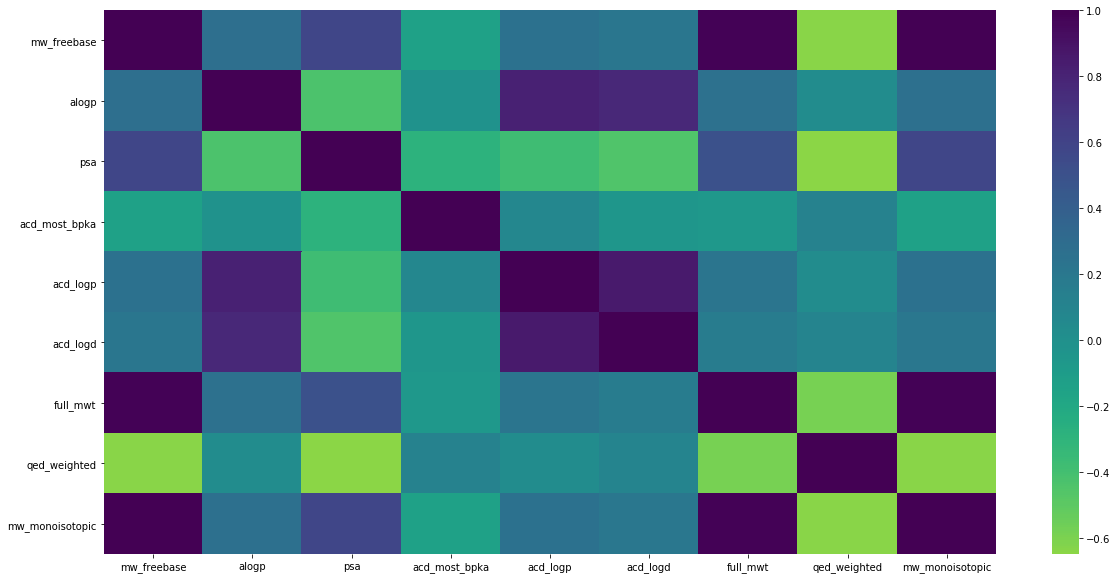

In [83]:
# correlation plot
plt.figure(figsize = [20, 10])
sns.heatmap(dfm[numeric_vars].corr(), cmap = 'viridis_r', center = 0);

> the heatmap above shows that there is certainly a correlation between the three types of molecular weight values, mw_freebase, full_mwt, and mw_monoisotopic. Intuition also points to this notion. Same goes with the acd_logp, acd_logd and alogp; they are highly correlated. the qed_weighted is not really linearly correlated with any of these since it is a complex equation that involves the exponential of the ratio of two summation products involving several of the molecular descriptors 
> it is interesting to see that the qed value is the only featre that has a very negative correlation with some other features, like polar surface area (psa) and mw_freebase. 

### pointplot to investagte country, full molecular weight and qed score

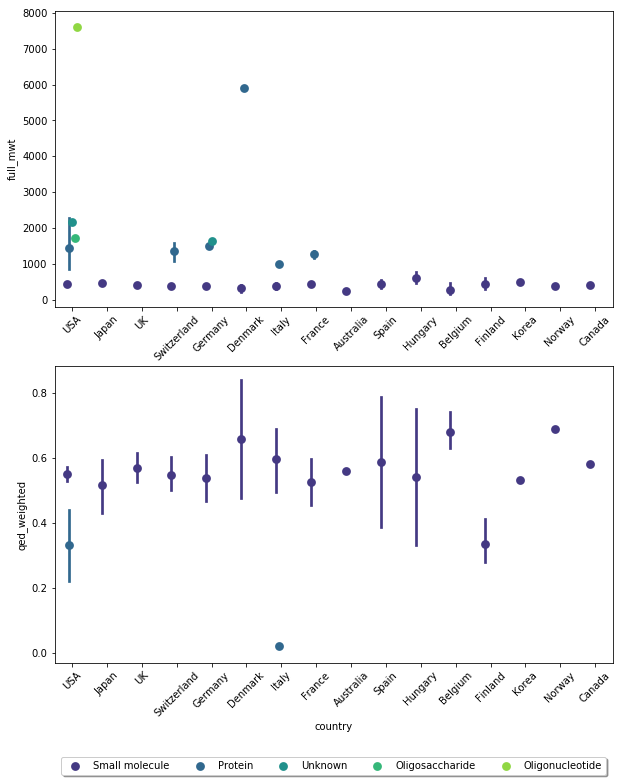

In [84]:
fig, ax = plt.subplots(2,1,figsize=(10,12))

# plot for full_mwt in y axis
p = sns.pointplot(data = dfm, 
             x = 'country', 
             y = 'full_mwt', 
             hue = 'molecule_type', 
             palette = 'viridis', 
             dodge = 0.3, 
             linestyles = "",
             ax=ax[0])
p.set_xticklabels(dfm.country.unique(),rotation=45)
ax[0].get_legend().remove()

# plot for qed_weighted in y axis
p2 = sns.pointplot(data = dfm, 
             x = 'country', 
             y = 'qed_weighted', 
             hue = 'molecule_type', 
             palette = 'viridis', 
             dodge = 0.3, 
             linestyles = "",
             ax=ax[1])
p2.set_xticklabels(dfm.country.unique(),rotation=45)
# legend
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5);

> - the pointplot above shows how the drugs compare in regards to qed_weighted and full molecular weight for each of the countries in the dataset. The top plot shows the peptide based drugs have very high molecular weights. The US developed these high molecular weight drugs. Most other countries developed purely small molecules. Both plots also show that small molecules are the dominant type of drug molecule. The bottom plot shows the range of values for the qed score. This is a calculation of many of the molecular descriptors. Italy seems to have developed a drug that has the lowest qed score. Denmark, Hungary and Spain developed drugs that have a range of qed scores. The qed scores are being balanced out so the 'hue' factor seems to be masked. 

### investigate the application types for the drugs

In [85]:
# melt the dataframe to unpivot the app_type_cols 
app_type_cols = ['oral', 'topical', 'parenteral']
non_app_type_cols = dfm.columns.difference(app_type_cols)
dfm_drugapp = dfm.melt(id_vars = non_app_type_cols,\
                       value_vars = app_type_cols,\
                       var_name = 'drug_app',\
                       value_name = 'app_type')
# must exlucde the 0 since they would just duplicate for all three sets
# it would just look like one type (colour) in the scatter plot
dfm_drugapp = dfm_drugapp[dfm_drugapp.app_type!=0]
dfm_drugapp.head()

,acd_logd,acd_logp,acd_most_bpka,ad_type,alogp,approval_date,aromatic_rings,availability_type,black_box_warning,canonical_smiles,...,qed_weighted,ro3_pass,route,rtb,structure_type,therapeutic_flag,trade_name,withdrawn_flag,drug_app,app_type
1,-2.24,0.89,NaN,RX,2.43,2003-08-12,2,1,0,[Ca+2].CC(C)c1nc(nc(c1\C=C\[C@@H](O)C[C@@H](O)...,...,0.47,N,ORAL,10,MOL,1,CRESTOR,0,oral,1
2,4.47,4.47,4.09,RX,3.99,2013-11-13,4,1,0,Nc1ncnc2c1c(nn2[C@@H]3CCCN(C3)C(=O)C=C)c4ccc(O...,...,0.47,N,ORAL,5,MOL,1,IMBRUVICA,0,oral,1
4,1.79,2.93,8.62,RX,2.90,1992-08-28,2,1,1,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,...,0.88,N,ORAL,1,MOL,1,AMOXAPINE,0,oral,1
5,2.22,2.22,1.17,DISCN,2.84,1987-08-10,2,1,0,OC1N=C(c2ccccc2)c3cc(Cl)ccc3NC1=O,...,0.85,N,ORAL,1,MOL,1,OXAZEPAM,0,oral,1
10,1.92,1.92,2.37,RX,3.51,2007-02-13,3,1,0,Cc1nnc2CN=C(c3ccccc3)c4cc(Cl)ccc4n12,...,0.69,N,ORAL,1,MOL,1,ALPRAZOLAM,0,oral,1


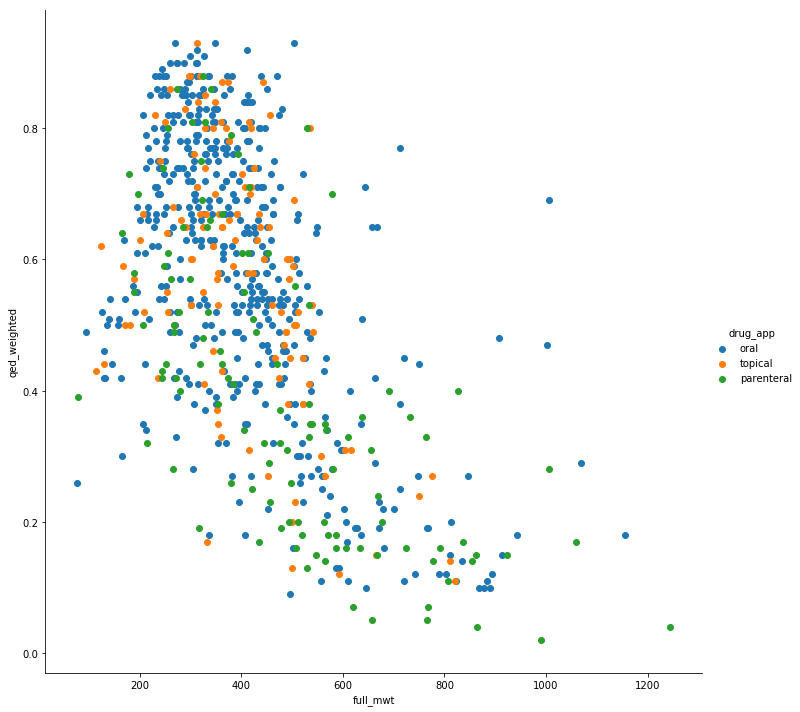

In [86]:
# relationship between drug application type  qed_wegihted and full_mwt
g = sns.FacetGrid(dfm_drugapp, hue='drug_app', height= 10)
g = g.map(plt.scatter, 'full_mwt', 'qed_weighted')
g.add_legend();

> it seems as though oral drugs have a better qed_weighted value (there is a higher density of datapoints in the 0.6-0.8 region on y-axis for oral types). 

In [87]:
# sort the dataframe based on previously sorted order of 
# the chem_chem_subgrp_dct_order dictionary
dfmc_order = dfmc[[f'{csb}_subgroup' for csb in chem_subgrp_dct_order.keys()]]
# exclude the _subgroup in the name just for the plotting since it is too long
dfmc_order.columns = [csb.split('_')[0] for csb in dfmc_order.columns] 
dfmc_order.head(1)

,benzene,ester,ether,double-bond,peptide-bond,terpene,cyclohexane,pyridine,oxy-cyclohexane,oxy-cyclopentane,nitrile,cyclohexanone,cyclopentanone
0,False,False,True,True,False,True,False,False,True,True,False,False,False


In [88]:
# there seems to be some strange values for 3
# drug compounds in the natural product column
dfm[dfm.natural_product==-1]

,molregno,canonical_smiles,compound_name,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,...,trade_name,approval_date,ad_type,oral,topical,parenteral,doc_id,black_box_warning,inorganic_flag,indication_class
186,1339278,NC(=N)c1ccc(\C=C\c2ccc(cc2O)C(=N)N)cc1.OCCS(=O...,4-(4-carbamimidoylstyryl)-3-hydroxybenzimidami...,280.32,1.69,3,5,119.96,4,N,...,HYDROXYSTILBAMIDINE ISETHIONATE,1982-01-01,DISCN,0,0,1,61872,0,-1,NaN
274,144744,C[C@H](Cc1ccc(O)c(O)c1)[C@@H](C)Cc2ccc(O)c(O)c2,SID144203761,302.36,4.71,4,4,80.92,5,N,...,ACTINEX,1992-09-04,DISCN,0,1,0,51887,0,-1,NaN
319,1031157,Cl.Cl.OC(=O)COCCN1CCN(CC1)C(c2ccccc2)c3ccc(Cl)cc3,CETIRIZINE HYDROCHLORIDE,388.89,0.45,5,1,53.01,8,N,...,CETIRIZINE HYDROCHLORIDE HIVES,2007-12-28,OTC,1,0,0,75466,0,-1,NaN


In [89]:
# change the natural product value for three rows (they should be 1 or 0 not -1)
# checking on the interenet it seems that Hydroxystilbamidine isethionate 
# and cetirizine hydrocholoride hives are synthetic drugs whereas actinex 
# is a natural product dervied drug
dfm[dfm.natural_product==-1].index.values

array([186, 274, 319])

In [90]:
# assign the value properly so that it can be visualised properly below
dfm.at[186, 'natural_product'] = 0
dfm.at[274, 'natural_product'] = 1
dfm.at[319, 'natural_product'] = 0

In [91]:
# dataframe with chemical subgroup concatenated
dfm_csb = pd.concat([dfm, dfmc_order], axis=1, sort=False)
dfm_csb.head()

,molregno,canonical_smiles,compound_name,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,...,double-bond,peptide-bond,terpene,cyclohexane,pyridine,oxy-cyclohexane,oxy-cyclopentane,nitrile,cyclohexanone,cyclopentanone
0,1073669,CO[C@H]1[C@@H](C[C@H](O)CN)O[C@H]2C[C@H]3O[C@@...,Eribulin Mesylate,729.90,0.97,12,2,146.39,4,N,...,True,False,True,False,False,True,True,False,False,False
1,1123018,[Ca+2].CC(C)c1nc(nc(c1\C=C\[C@@H](O)C[C@@H](O)...,ROSUVASTATIN CALCIUM,481.54,2.43,8,3,149.29,10,N,...,True,False,False,False,False,False,False,False,False,False
2,1214046,Nc1ncnc2c1c(nn2[C@@H]3CCCN(C3)C(=O)C=C)c4ccc(O...,NaN,440.50,3.99,6,1,99.16,5,N,...,True,True,False,False,False,False,False,False,False,False
3,14125,CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1C...,DINOPROSTONE,352.47,3.20,5,3,94.83,12,N,...,True,False,False,False,False,False,False,False,False,True
4,155045,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,Amoxapine,313.78,2.90,4,1,36.86,1,N,...,False,False,False,False,False,False,False,False,False,False


In [92]:
# melt the dataframe to unpivot the chemical subgroup columns
subgroup_cols = dfmc_order.columns 
non_subgroup_cols = dfm_csb.columns.difference(subgroup_cols)
dfm_csb_melt = dfm_csb.melt(id_vars = non_subgroup_cols,\
                       value_vars = subgroup_cols,\
                       var_name = 'chemical_subgroup',\
                       value_name = 'bool_subgroup')
# must exlucde the False since they would just replicate for all 13 sets
dfm_csb_melt = dfm_csb_melt[dfm_csb_melt.bool_subgroup==True]
dfm_csb_melt.head()

,acd_logd,acd_logp,acd_most_bpka,ad_type,alogp,approval_date,aromatic_rings,availability_type,black_box_warning,canonical_smiles,...,ro3_pass,route,rtb,structure_type,therapeutic_flag,topical,trade_name,withdrawn_flag,chemical_subgroup,bool_subgroup
1,-2.24,0.89,NaN,RX,2.43,2003-08-12,2,1,0,[Ca+2].CC(C)c1nc(nc(c1\C=C\[C@@H](O)C[C@@H](O)...,...,N,ORAL,10,MOL,1,0,CRESTOR,0,benzene,True
2,4.47,4.47,4.09,RX,3.99,2013-11-13,4,1,0,Nc1ncnc2c1c(nn2[C@@H]3CCCN(C3)C(=O)C=C)c4ccc(O...,...,N,ORAL,5,MOL,1,0,IMBRUVICA,0,benzene,True
4,1.79,2.93,8.62,RX,2.90,1992-08-28,2,1,1,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,...,N,ORAL,1,MOL,1,0,AMOXAPINE,0,benzene,True
5,2.22,2.22,1.17,DISCN,2.84,1987-08-10,2,1,0,OC1N=C(c2ccccc2)c3cc(Cl)ccc3NC1=O,...,N,ORAL,1,MOL,1,0,OXAZEPAM,0,benzene,True
6,-2.34,0.16,13.52,RX,1.27,2011-06-29,1,1,0,C[C@@H]1CCN([C@H](C1)C(=O)O)C(=O)[C@H](CCCNC(=...,...,N,IV (INFUSION),10,MOL,1,0,ARGATROBAN IN SODIUM CHLORIDE,0,benzene,True


### violinplot of qed score and chemical subgroup showing relationship with various categorical variables

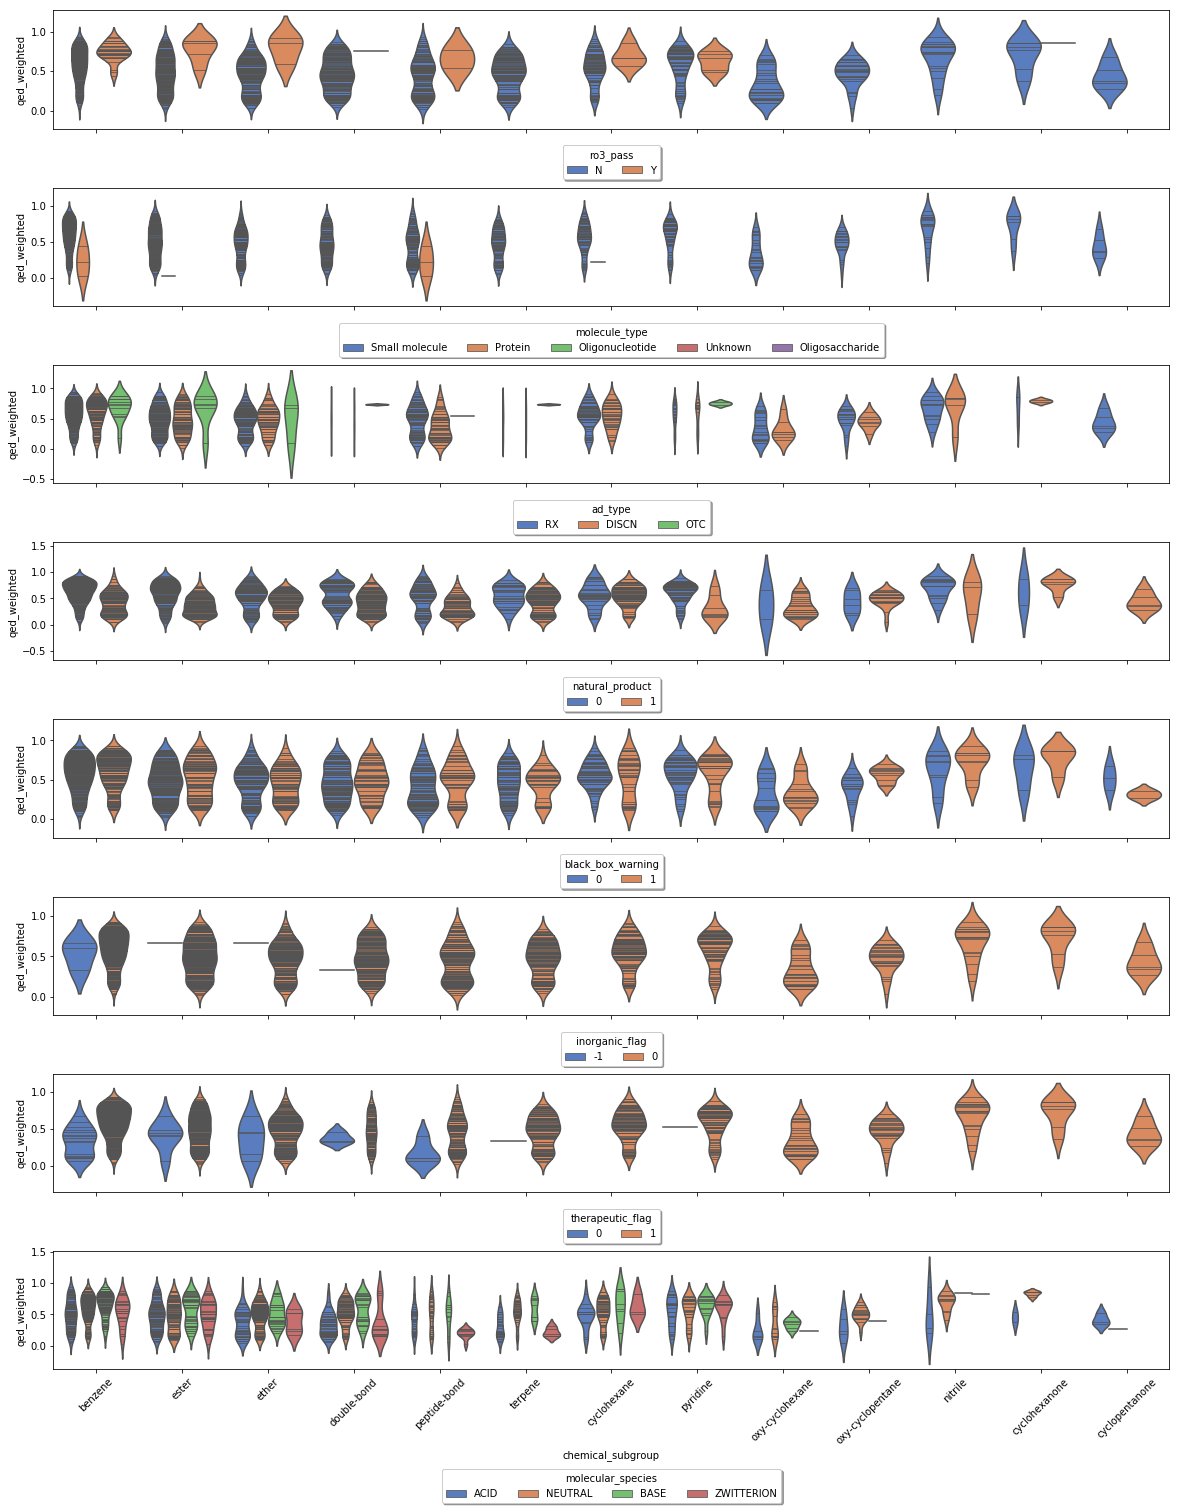

In [93]:
# plot the categorical variables against qed_weighted 
var_lst = ['ro3_pass',\
            'molecule_type',\
            'ad_type',\
            'natural_product',\
            'black_box_warning',\
            'inorganic_flag',\
            'therapeutic_flag',\
            'molecular_species'
          ]

f, ax = plt.subplots(len(var_lst),1, figsize=(20,25))
for i,var in enumerate(var_lst):
    p = sns.violinplot(x="chemical_subgroup", y="qed_weighted", hue=var,
                        data=dfm_csb_melt, palette="muted", inner='stick',ax=ax[i]);
    if i == len(var_lst)-1:
        p.set_xticklabels(subgroup_cols, rotation=45);
        legend_voffset = -0.8
    else:
        p.set_xticklabels([])
        p.set_xlabel('')
        legend_voffset = -0.1
        
    ax[i].legend(title=var_lst[i],\
                loc='upper center',\
                bbox_to_anchor=(0.5, legend_voffset),\
                fancybox=True,\
                shadow=True,\
                ncol=len(dfm_csb_melt[var].unique()))
    
# create more vertical padding
plt.subplots_adjust(hspace = 0.5)

In [94]:
# the number of drugs that are discontinued
dfm[dfm.ad_type == 'DISCN'].shape[0]

240

In [95]:
# number of natural products in dataset
dfm[dfm.natural_product == 1].shape[0]

213

In [96]:
# number of black-box warning in dataset
dfm[dfm.black_box_warning == 1].shape[0]

272

In [97]:
# count the types of molecular species for this dataset
dfm['molecular_species'].value_counts()

NEUTRAL       349
ACID          171
BASE          134
ZWITTERION     41
Name: molecular_species, dtype: int64

> - This clustered violin plot shows different facets of qed_weighted vs the chemical subgroup type and in each case, a third variable as the hue. Many of the distributions are not unimodal, there are more than just one hump in the violin plot. 
> - From the top, the hue variable is ro3_pass which is whether the drug compound passed the rule of 3 (molecular weight is <300, the number of hydrogen bond donors is ≤3, the number of hydrogen bond acceptors is ≤3 and ClogP is ≤3). There are actually very few drug compounds that actually pass the rule of 3. Perhaps this rule is not a very good rule in regards to chemical efficiacy, or is the reason why 240 drugs in this dataset were labelled as discontinued. 
> - The second violing plot shows the hue variable as the molecule type. Since this dataset is very sparse and heavily weighted on small-molecules, the data doesn't really reveal anything substantial other than the small molecules have the following chemical subgroups: benzene, ester, ether, double-bond, peptide bonds and terpenes. So there seems to be small-molecules have have peptide bonds. 
> - Again the data is a bit sparse for this hue variable, ad-type. What is surprising is the amount of discontinued drugs (240). Most drugs are prescribed, perhaps to make more profit and at the same time control the distribution of these specialised drugs. Drugs that are OTC typically have benzene, ester and ether chemical groups. They have a relatively high qed value, but there really isn't enough data to confirm. 
> -  Natural products or synthesised seem to not make any difference in regards to qed values. However, natural products that have higher qed values have nitrile, cyclohexanone, and cyclopentanone chemical subgroups.
> - 272 drugs of this dataset have blackbox warnings. There aren't any major differences in the qed values besides the right side of the chemical subgroup. However, the data is more sparse in that space. 
> - likewise, inorganic flag doesn't really give much interpretation. Most are organic compounds in this dataset. 
> - Most drugs in this dataset do have therapeutic purposes and not just to act as an additive or imaging agent. Again it seems that the chemical subgroups on the right-hand side have higher qed values, but the data is a bit sparse. It makes sense that compounds that don't have therapeutic properties, will have lower qed scores which can be observed on the left hand side of the chemical subgroup space. 
> - In this dataset, neutral compounds are the most common at 349. the least are zwitterions which are molecules or ion having separate positively and negatively charged groups. The nitrile group is acidic and seems to have the highest qed scores. Since benzene chemical subgroups are so ubiquitous they have very densely populated violin plots for all molecular species. Molecules or compounds that have peptide bonds and are considered a zwitterion have very low qed scores, likewise with terpenes.

### hist2d plot showing relationship of full molecular weight, qed score and polar surface area

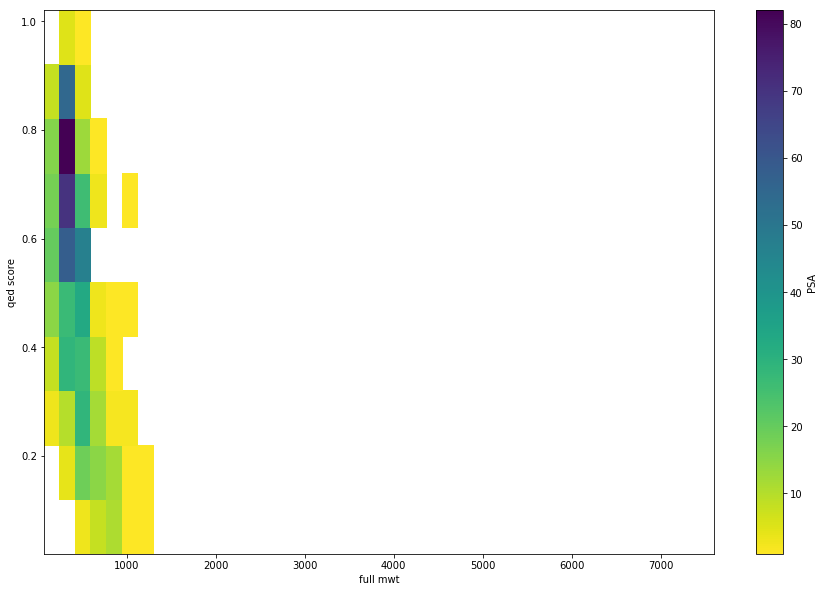

In [98]:
xbin_edges = np.arange(dfm['full_mwt'].min(), dfm['full_mwt'].max()+175, 175)
ybin_edges = np.arange(dfm['qed_weighted'].min(), dfm['qed_weighted'].max()+0.1, 0.1)

# count number of points in each bin
xbin_idxs = pd.cut(dfm['full_mwt'], xbin_edges, right = False,
                    include_lowest = True, labels = False)
ybin_idxs = pd.cut(dfm['qed_weighted'], ybin_edges, right = False,
                    include_lowest = True, labels = False).fillna(0).astype(int)

plt.figure(figsize=(15,10))
plt.hist2d(data = df, x = 'full_mwt', y = 'qed_weighted',
           bins = [xbin_edges, ybin_edges], cmap = 'viridis_r', cmin = 0.5);
plt.colorbar(label = 'PSA');
plt.xlabel('full mwt')
plt.ylabel('qed score');

> This hist2d plot shows that as polar surface area increases, the qed score follows; as shown in the purple cells in the 0.6 - 0.8 region. If the drug compound has higher polar surface area this may mean it has a better chance of attaching or binding to the site of interest, whether it be a protein or some targeted part of a cell

### PCA analysis

In [99]:
# Separating out the features (have to be numeric)
features = numeric_vars[:-1] + ['hba','hbd',\
                                'rtb','num_ro5_violations',\
                                'aromatic_rings','heavy_atoms',\
                                'num_alerts','hba_lipinski',\
                                'hbd_lipinski','num_lipinski_ro5_violations']

In [100]:
# show what columns have nans
for f in features:
    if any(dfm[f].isnull()):
        print(f) 

mw_freebase
alogp
psa
acd_most_bpka
acd_logp
acd_logd
qed_weighted


In [101]:
# remove the nan rows
filter_nans = (
 ~dfm.mw_freebase.isnull() &\
 ~dfm.alogp.isnull() &\
 ~dfm.psa.isnull() &\
 ~dfm.acd_most_bpka.isnull() &\
 ~dfm.acd_logp.isnull() &\
 ~dfm.acd_logd.isnull() &\
 ~dfm.qed_weighted.isnull()
)

In [102]:
dfm_pca = dfm[filter_nans]

In [103]:
dfm_pca.shape

(485, 47)

In [104]:
x = dfm_pca.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [105]:
# automatically analyse so that 95% of variance is explained
pca = PCA(n_components=.95)
pcp_compts= pca.fit_transform(x)
# create dataframe
pcp_df = pd.DataFrame(data = pcp_compts)
pcp_df.head(20)

,0,1,2,3,4,5,6,7,8
0,4.361952,-1.052696,0.733773,0.403936,-0.839174,3.586822,0.410716,0.349473,0.241397
1,0.025513,-2.080521,-1.213927,-0.958987,-0.150564,-0.640886,0.327227,-1.339395,-0.311240
2,-2.741471,-0.322164,0.446841,-0.583941,-0.043112,0.829234,-0.160792,-0.445891,-0.154636
3,-2.418544,0.116007,-1.192810,-1.446831,0.920811,0.111086,0.768294,0.190244,0.596681
4,5.221314,1.669334,3.019078,1.533686,1.506305,-0.130263,-0.396532,-0.311043,0.043457
5,-1.825057,0.566192,0.315298,-0.607191,-0.353606,1.031816,0.495547,0.085300,0.038451
6,0.325321,-2.895955,0.022444,-0.103466,-0.843497,0.412619,-0.703715,0.048027,-0.419694
7,-2.660747,-0.879963,-1.502826,-1.123468,0.813424,0.096789,-0.568914,-0.114988,0.274997
8,-3.587766,2.422673,0.809890,0.342906,1.295304,-0.166556,-0.502375,-0.039514,-0.283813
9,-0.280761,-0.374299,-0.057641,-0.601702,-1.059087,-0.345636,-0.166248,0.675508,-0.011293


In [107]:
# make list of the target columns
tgt_lst = [
'natural_product',\
'molecular_species',\
'molecule_type',\
'ad_type',\
'good_flag'] # added later downstream

In [108]:
# indices of drugs that are not discontinued and have high qed score
idx_good_drgs = dfm[(dfm.ad_type != 'DISCN') & (dfm.qed_weighted > 0.62)].notna().index
idx_good_drgs

Int64Index([  4,   7,  10,  13,  14,  15,  19,  20,  25,  26,
            ...
            693, 694, 704, 706, 713, 715, 718, 722, 724, 728],
           dtype='int64', length=200)

In [109]:
# get intersection of both
intsct_idx = list(set(idx_good_drgs) & set(dfm_pca.index))

In [110]:
# best drugs in the dataset
dfm_good_drg = dfm_pca.loc[intsct_idx]
dfm_good_drg.head()

,molregno,canonical_smiles,compound_name,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,...,trade_name,approval_date,ad_type,oral,topical,parenteral,doc_id,black_box_warning,inorganic_flag,indication_class
4,155045,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,Amoxapine,313.78,2.90,4,1,36.86,1,N,...,AMOXAPINE,1992-08-28,RX,1,0,0,59306,1,0,Antidepressant
7,21459,Oc1ccc2C[C@H]3N(CC4CC4)CC[C@@]56[C@@H](Oc1c25)...,Naltrexone,341.40,1.66,5,2,70.00,2,N,...,VIVITROL,2006-04-13,RX,0,0,1,59306,1,0,Antagonist (to narcotics)
521,59519,CN1CCN(CC1)C2=Nc3ccccc3Oc4ccc(Cl)cc24,NaN,327.81,3.43,4,0,28.07,1,N,...,ADASUVE,2012-12-21,RX,0,1,0,84147,1,0,Tranquilizer (minor)
10,27648,Cc1nnc2CN=C(c3ccccc3)c4cc(Cl)ccc4n12,ALPRAZOLAM,308.76,3.51,3,0,43.07,1,N,...,ALPRAZOLAM,2007-02-13,RX,1,0,0,75454,0,0,Sedative-Hypnotic
523,674283,Cl.CNCCCC1c2ccccc2C=Cc3ccccc13,Protriptyline Hydrochloride,263.38,4.04,1,1,12.03,4,N,...,PROTRIPTYLINE HYDROCHLORIDE,2012-11-19,RX,1,0,0,-1,1,0,Antidepressant


In [111]:
# assign categorical var to this new column 
dfm_pca['good_flag'] = 'substandard'
for i,r in dfm_pca.iterrows():
    if i in dfm_good_drg.index:
        dfm_pca.at[i, 'good_flag'] = 'excellent'

/Users/trinhsk/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
# concatenate the target columns
df_pca_tgt = pd.concat([pcp_df,\
                        dfm_pca['natural_product'],\
                        dfm_pca['molecular_species'],\
                        dfm_pca['molecule_type'],\
                        dfm_pca['route'],\
                        dfm_pca['ad_type'],\
                        dfm_pca['good_flag']],\
                        axis = 1)

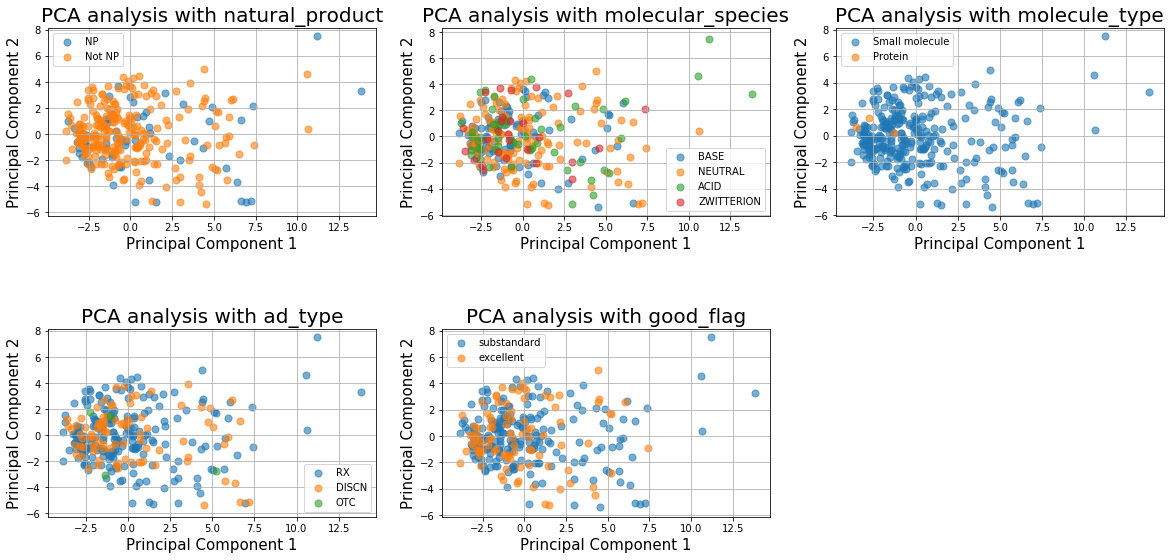

In [113]:
# pca subplots 
fig = plt.figure(figsize = (20,9))
rows = 2
cols = 3
for idx,tgt in enumerate(tgt_lst):
    # last plot in the middle
    ax = fig.add_subplot(rows,cols,idx+1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(f'PCA analysis with {tgt_lst[idx]}', fontsize = 20)
    targets = dfm_pca[tgt].unique()
    colors = sns.color_palette()[:len(targets)]
    for tgt_ ,col in zip(targets,colors):
        idx_tgt = df_pca_tgt[tgt] == tgt_ 
        ax.scatter(df_pca_tgt.loc[idx_tgt, 0],
                    df_pca_tgt.loc[idx_tgt, 1],
                    color = col,
                    s = 50,
                    alpha = 0.6)
    # manually enter the legend entries 
    # for natural_product since it is 1 or 0
    if tgt == 'natural_product':
        ax.legend(['NP', 'Not NP'])
    else:
        ax.legend(targets)
    ax.grid()
    
plt.subplots_adjust(hspace = 0.6)

In [114]:
dfm_good_drg.shape

(139, 47)

> - this plot of pca only shows the first two components since they are the most important and it is easier to just see in two dimensions. The dataframe shows that there are 8 principal components however. The first plot seems to imply that natural product based drugs and synthesised drugs are for the most part difficult to distinguish. Perhaps a more rigourous analysis can be conducted with a larger dataset that may provide more insight. 
> - the second pca plot shows that acid type compounds vary across the two principal components more than the others. 
> - the third plot does not have enough data for proteins to make any conclusive remarks
> - the administration type for the drug doesn't seem to separate by PCA analysis either. Because the amount of prescribed drugs have more datapoints, it carries more weight. 
> - the last subplot shows a new flag entered by indexing the dataframe with a conditon that the qed score is > 0.62 and the drug is not discontinued. There are about 139 of these compounds in the dataset.  
> - Overall there is more varaition in principal comoponent 1 compared to 2. the first principal component actually comprises of 44% of the variation as can be seen below. The second comprises of half that value and the remainder are very miniscule.  

In [115]:
# explained variance for the pca analysis
pca.explained_variance_ratio_

array([0.44170887, 0.25628276, 0.07074053, 0.05470531, 0.03946999,
       0.03187109, 0.0256755 , 0.02066358, 0.01462216])

In [117]:
# descriptive statistics on the numerical features
dfm[features].describe()

,mw_freebase,alogp,psa,acd_most_bpka,acd_logp,acd_logd,full_mwt,qed_weighted,hba,hbd,rtb,num_ro5_violations,aromatic_rings,heavy_atoms,num_alerts,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations
count,740.000000,717.000000,717.000000,485.000000,717.000000,714.000000,750.000000,717.000000,750.000000,750.000000,750.000000,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,428.973270,2.370098,93.431967,6.661588,2.357922,1.053922,463.672533,0.550195,4.993333,1.873333,5.558667,0.36000,1.484000,25.386667,0.928000,5.901333,2.117333,0.254667
std,407.883391,2.412028,56.458324,3.035586,2.279674,2.790356,426.957893,0.221652,3.093765,1.657192,4.120501,0.70739,1.168859,11.436121,1.088912,3.590653,1.878014,0.529955
min,76.050000,-6.840000,0.000000,0.040000,-7.940000,-7.950000,73.890000,0.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,291.142500,0.870000,53.090000,4.380000,1.000000,-0.615000,302.915000,0.400000,3.000000,1.000000,3.000000,0.00000,1.000000,19.000000,0.000000,3.250000,1.000000,0.000000
50%,361.830000,2.620000,83.830000,7.390000,2.530000,1.245000,392.430000,0.570000,5.000000,2.000000,5.000000,0.00000,1.000000,25.000000,1.000000,5.000000,2.000000,0.000000
75%,468.425000,4.010000,119.110000,9.080000,3.780000,2.977500,505.027500,0.730000,6.750000,3.000000,8.000000,0.00000,2.000000,31.000000,1.000000,8.000000,3.000000,0.000000
max,7177.150000,9.780000,355.740000,13.520000,9.000000,9.000000,7594.800000,0.930000,19.000000,14.000000,26.000000,3.00000,6.000000,67.000000,6.000000,23.000000,14.000000,2.000000


In [119]:
# mean values of the numeric features
dfm[features].describe().iloc[1,:]

mw_freebase                    428.973270
alogp                            2.370098
psa                             93.431967
acd_most_bpka                    6.661588
acd_logp                         2.357922
acd_logd                         1.053922
full_mwt                       463.672533
qed_weighted                     0.550195
hba                              4.993333
hbd                              1.873333
rtb                              5.558667
num_ro5_violations               0.360000
aromatic_rings                   1.484000
heavy_atoms                     25.386667
num_alerts                       0.928000
hba_lipinski                     5.901333
hbd_lipinski                     2.117333
num_lipinski_ro5_violations      0.254667
Name: mean, dtype: float64

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> In this his2d plot, it was observed that as psa increases so does the qed score. This makes sense since if the drug can bind to its target better than the drug-likeness factor (qed score) increases. The violinplot's first subplot shows that most of the drugs in this dataset did not pass the ro3 rule, however, it is probably due to the scarity of the dataset. If there were more datapoints, the gap may have been filled. The violinplot seems to show that the right-side chemical subgroups, although more rare in this dataset, may lead to higher qed scores.  

### Were there any interesting or surprising interactions between features?

> The PCA analysis did not show any striking differences probably because the variables that were used to facet the subplots weren't that meaningful. Perhaps only the natural product variable would be significant. But the data is quite sparse so there was no clear separation of the datapoints. This analysis has been done and has been reported in the literature that natural products typically form their own group in PCA. Principal comonent 1 (mw_freebase) is the most varied component out of the eight. Acid and base chemical subgroup have plenty of datapoints in the violinplot. It makes sense that positively/negatively charged compounds would be more efficacious. 